## MINERvA's Boosted Decision Tree Neutrino MC Events Reweight with GENIE and NUISANCE Flat Tree
This note book demonstrates a reweight analysis using MINERvA's GENIE medium energy numu-carbon MC events. 

In [1]:
import sys
# Change this path to your working directory where BDTReweight is installed:
sys.path.append('/exp/minerva/app/users/zihaolin/REWEIGHTworkdir/')

from BDTReweight.analysis import transform_momentum_to_reaction_frame, create_dataframe_from_nuisance, draw_source_target_distributions_and_ratio
from BDTReweight.nuisance_flat_tree import NuisanceFlatTree
from BDTReweight.reweighter import Reweighter
from BDTReweight.utilities import particle_variable_to_latex, diff_xsec_latex_wrt_variable
import numpy as np
import pandas as pd
import time

### MINERvA's ME numu-carbon CCQE-like 1mu1p0n reweight demo
- Source generator: GENIE v2.12.6
- Target generator: GENIE v3.04.00 tune AR23_20i_00_000

This notebook uses GENIE MC sample NUISANCE flat tree root files stored on MINERvA GPVM.

Prepare trees from MC samples for training:

In [2]:
# prepare source sample NuisanceFlatTree for training
tree_source_train = NuisanceFlatTree(
    # A GENIE v2.12.6 sample (prepared by Dan Ruterbories):
    '/pnfs/minerva/persistent/Models/GENIE/Medium_Energy/FHC/v2_12_6/tracker/minervabase/Flattened_GENIE_v2_12_6_DefaultMEC_numu_CH_100_ghep.root'
)
# GENIE v2 CCQE-like final state has these particles: muon, proton, neutron, 25 MeV binding energy place holder
# Their pdg: 13, 2212, 2112, 2000000101
# GENIE v3 doesn't have this place holder.
mask_CCQELike = (tree_source_train.get_mask_final_state_allowed_pdg([13, 2212, 2112, 2000000101])
        & tree_source_train.get_mask_topology({'proton':'>=1'}))
tree_source_train.update_tree_with_mask(mask_CCQELike)


# prepare target sample NuisanceFlatTree for training
tree_target_train = NuisanceFlatTree(
    # A GENEIE v3.04.00 AR23 sample:
    '/exp/minerva/data/users/zihaolin/MC_outputs/GENIE/GENIEv3_AR23_MINERvA_ME_FHC_numu_C12_NUISFLAT.root',
    # Alternatively, try GENIE v3 G18_10a:
    # '/pnfs/minerva/persistent/Models/GENIE/Medium_Energy/FHC/v3_0_6/tracker/G18_10a_02_11a/CH/flat_GENIE_G18_10a_02_11a_50M.root',
    # Use akward array's kwargs to control sample size
    entry_start=0, entry_stop=1000000
)
mask_CCQELike = (tree_target_train.get_mask_final_state_allowed_pdg([13, 2212, 2112])
        & tree_target_train.get_mask_topology({'proton':'>=1'}))
tree_target_train.update_tree_with_mask(mask_CCQELike)


# prepare source sample NuisanceFlatTree for testing
tree_source_test = NuisanceFlatTree(
    # A statistically independent GENIE v2.12.6 sample (prepared by Dan Ruterbories):
    '/pnfs/minerva/persistent/Models/GENIE/Medium_Energy/FHC/v2_12_6/tracker/minervabase/Flattened_GENIE_v2_12_6_DefaultMEC_numu_CH_101_ghep.root'
)
mask_CCQELike = (tree_source_test.get_mask_final_state_allowed_pdg([13, 2212, 2112, 2000000101])
        & tree_source_test.get_mask_topology({'proton':'>=1'}))
tree_source_test.update_tree_with_mask(mask_CCQELike)

# prepare target sample NuisanceFlatTree for testing
tree_target_test = NuisanceFlatTree(
    # A GENEIE v3.04.00 AR23 sample:
    '/exp/minerva/data/users/zihaolin/MC_outputs/GENIE/GENIEv3_AR23_MINERvA_ME_FHC_numu_C12_NUISFLAT.root',
    entry_start=1000000, entry_stop=2000000
)
mask_CCQELike = (tree_target_test.get_mask_final_state_allowed_pdg([13, 2212, 2112])
        & tree_target_test.get_mask_topology({'proton':'>=1'}))
tree_target_test.update_tree_with_mask(mask_CCQELike)

# Set conversion factor from event rate to cross-section:
scale_source_test = tree_source_test.get_conversion_factor_eventrate_to_xsec()
# For this AR23 sample, Since we only use 1M of the generated 4M events, the fScaleFactor need to scale up by 4 
scale_target_test = tree_target_test.get_conversion_factor_eventrate_to_xsec() * 4


### GENIE v2's elastic FSI bug events
Needs to pay extra attention to the elastic FSI bug in GENIE v2: 
the elastic FSI fate protons can change angle unphysically, so these events will be dropped.

$cos(\theta)$ for angle $\theta$ between vertex and final state proton momentum is checked to filter these events.

In [3]:
# Drop FSI bug events for GENIE v2 train and test sets
indices_good_FSI = tree_source_train.get_indices_genie2_drop_fsibug_events()
tree_source_train.update_tree_with_mask(indices_good_FSI)

indices_good_FSI = tree_source_test.get_indices_genie2_drop_fsibug_events()
tree_source_test.update_tree_with_mask(indices_good_FSI)

### CCQE-like final state topologies
The nucleon contents of CCQE-like final sate topologies can be divided into these categories:
* 0p0n
* 0pNn
* 1p0n
* 1pNn
* 2p0n
* 2pNn
* others ($\ge 3$ protons)

where we set kinetic energy detecting threshold to be 50 MeV and 10 MeV for proton and neutron, and $N\ge1$.
These categories have different training variables and will be reweighted seperately.

See more at <arXiv:2510.07463> Table I and the discussions there.

In [4]:
# Specify detecting thresholds and topology particle counts:
KE_thresholds={'proton':0.05, 'neutron':0.01}

# Create dictionaries to store dataframes later:
source_train = {}
target_train = {}
source_test = {}
target_test = {}


### CCQE-like 1 $\mu$ 0p0n:

In [5]:
# Category name:
category = '0p0n'

# Specify particle counts in final state:
particle_counts = {'muon':'==1', 'proton':'==0', 'neutron':'==0'}

# List variables to extract from tree:
variable_exprs = [
    'Enu_true', 'Q2', 'q0', 'q3', 'W',
    'leading_muon_px', 'leading_muon_py', 'leading_muon_pz', 'leading_muon_KE',
    'total_proton_px', 'total_proton_py', 'total_proton_pz', 'total_proton_KE',
]

# Specify reweight training variables:
reweight_variables=['total_proton_px','total_proton_py','total_proton_pz','total_proton_KE','leading_muon_py','leading_muon_pz']

# Specify selector_particle's whose momentum are transformed to reaction frame:
# (leading muon px py pz is assumed to be transformed)
particle_names = ['total_proton']

# Create a mask for the topology and create dataframes:
mask = tree_source_train.get_mask_topology(particle_counts = particle_counts, KE_thresholds = KE_thresholds)
source_train[category] = create_dataframe_from_nuisance(tree_source_train, variable_exprs=variable_exprs, mask=mask)

mask = tree_target_train.get_mask_topology(particle_counts = particle_counts, KE_thresholds = KE_thresholds)
target_train[category] = create_dataframe_from_nuisance(tree_target_train, variable_exprs=variable_exprs, mask=mask)

mask = tree_source_test.get_mask_topology(particle_counts = particle_counts, KE_thresholds = KE_thresholds)
source_test[category] = create_dataframe_from_nuisance(tree_source_test, variable_exprs=variable_exprs, mask=mask)

mask = tree_target_test.get_mask_topology(particle_counts = particle_counts, KE_thresholds = KE_thresholds)
target_test[category] = create_dataframe_from_nuisance(tree_target_test, variable_exprs=variable_exprs, mask=mask)


# Convert to reaction frame:
source_train[category] = transform_momentum_to_reaction_frame(source_train[category], selector_lepton='leading_muon', particle_names=particle_names)
target_train[category] = transform_momentum_to_reaction_frame(target_train[category], selector_lepton='leading_muon', particle_names=particle_names)
source_test[category] = transform_momentum_to_reaction_frame(source_test[category], selector_lepton='leading_muon', particle_names=particle_names)
target_test[category] = transform_momentum_to_reaction_frame(target_test[category], selector_lepton='leading_muon', particle_names=particle_names)


# Create a Reweighter (inherited from hep_ml.reweight.GBReweighter) instance: 
reweighter = Reweighter(n_estimators=100, learning_rate=0.1, max_depth=4, min_samples_leaf=30, gb_args={'subsample': 1.0})

# Traing reweighter using source and target sample's reweight variables:
start_time = time.perf_counter()
reweighter.fit(source_train[category][reweight_variables], target_train[category][reweight_variables])
end_time = time.perf_counter()
print(f'Elapsed time: {(end_time-start_time):.3f} sec')


Elapsed time: 2.992 sec


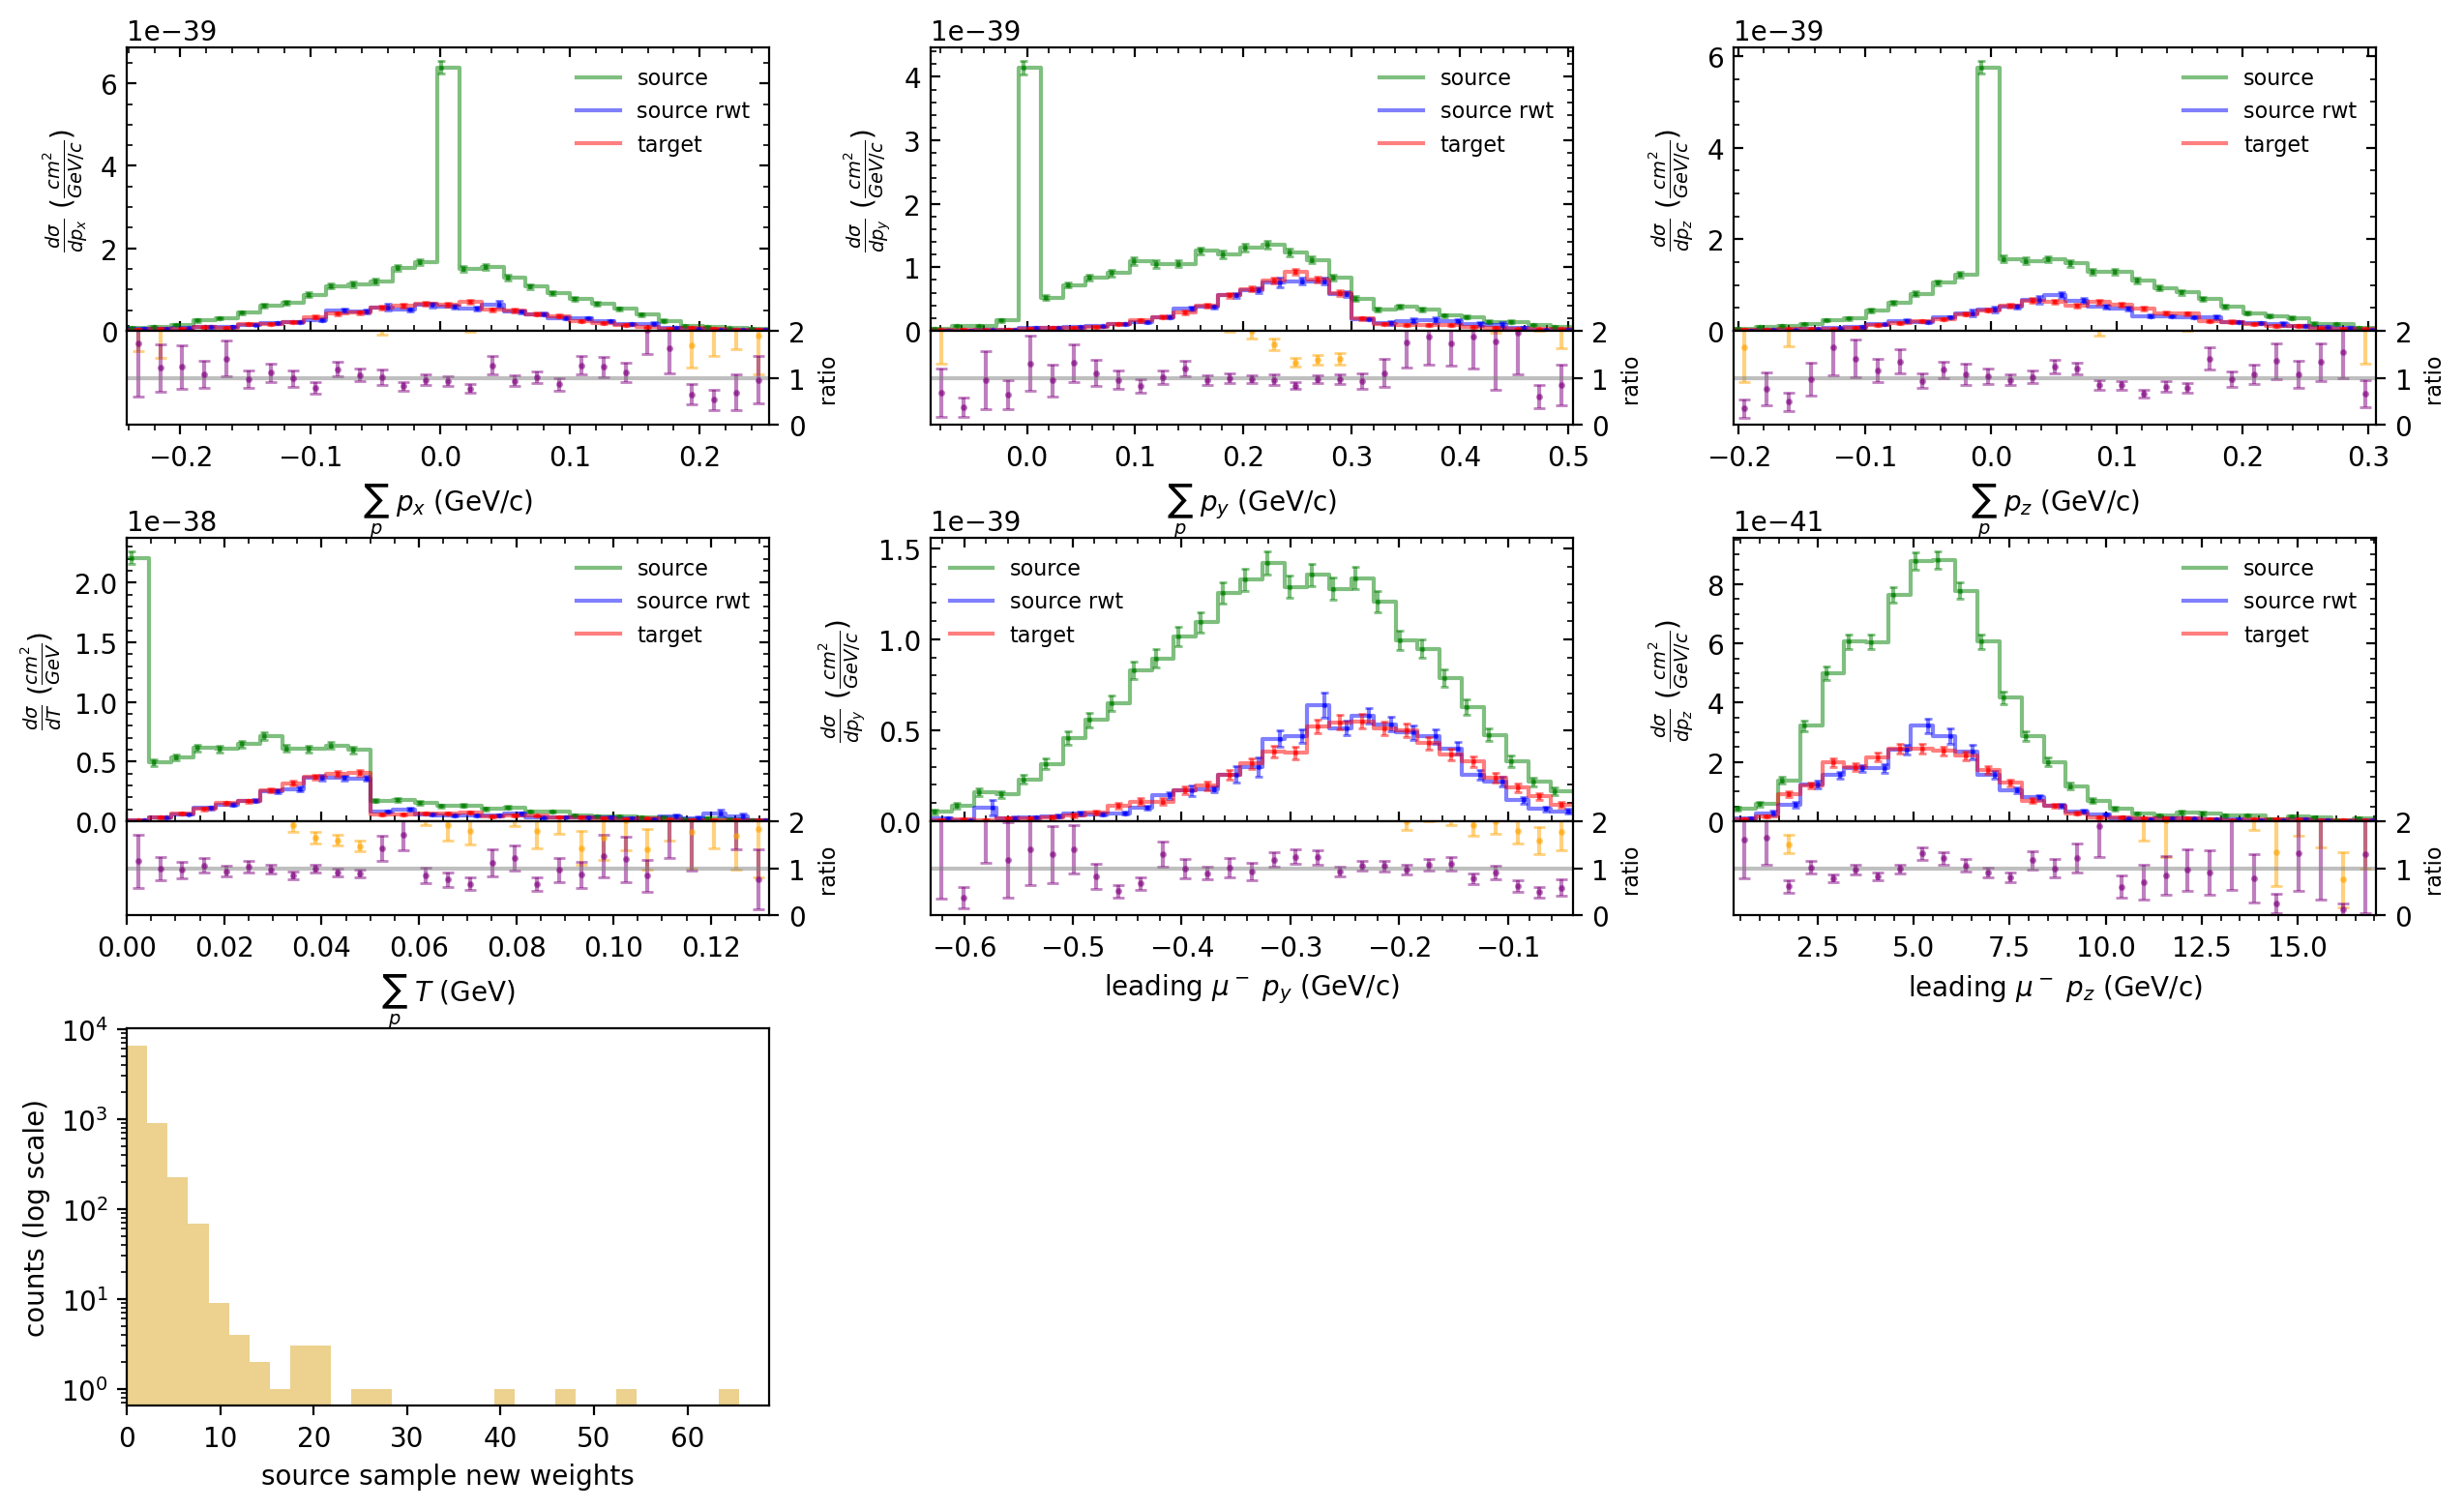

In [6]:
# Set target weights to 1.0 for all events:
target_test[category]['weight'] = 1.0

# Specify variables to be plotted as histograms:
drawing_variables = ['total_proton_px','total_proton_py','total_proton_pz','total_proton_KE','leading_muon_py','leading_muon_pz', 'weight']

# Predict weights for source model:
source_test[category]['weight'] = reweighter.predict_matched_total_weights(
    source_test[category][reweight_variables], 
    original_weight=None,
    target_weight=target_test[category]['weight']
)

# Draw distribution histograms:
draw_source_target_distributions_and_ratio(source_test[category], target_test[category], 
    variables = drawing_variables,
    source_weights = np.ones(len(source_test[category])),
    target_weights = np.ones(len(target_test[category])), 
    new_source_weights = source_test[category]['weight'],
    xlabels = [particle_variable_to_latex(var) for var in drawing_variables],
    ylabels = [diff_xsec_latex_wrt_variable(var) for var in drawing_variables],
    scale_source = scale_source_test, scale_target = scale_target_test
)

# Save reweighter to a path:
reweighter.save_to_pickle(f'/exp/minerva/data/users/zihaolin/BDTReweighters/saved_reweighters_pickle/reweighter_MINERvA_ME_numuCarbon_CCQELike_GENIEv2_to_v3AR23_1mu{category}.pkl')


### CCQE-like 1 $\mu$ 0pNn:

In [7]:
# Category name:
category = '0pNn'

# Specify particle counts in final state:
particle_counts = {'muon':'==1', 'proton':'==0', 'neutron':'>=1'}

# List variables to extract from tree:
variable_exprs = [
    'Enu_true', 'Q2', 'q0', 'q3', 'W',
    'leading_muon_px', 'leading_muon_py', 'leading_muon_pz', 'leading_muon_KE',
    'leading_neutron_px', 'leading_neutron_py', 'leading_neutron_pz', 'leading_neutron_KE',
    'total_proton_px', 'total_proton_py', 'total_proton_pz', 'total_proton_KE',
]

# Specify reweight training variables:
reweight_variables = [
    'leading_neutron_px', 'leading_neutron_py', 'leading_neutron_pz',
    'total_proton_px','total_proton_py','total_proton_pz',
    'total_proton_KE','leading_muon_py','leading_muon_pz'
]

# Specify selector_particle's whose momentum are transformed to reaction frame:
# (leading muon px py pz is assumed to be transformed)
particle_names = ['leading_neutron','total_proton']

# Create a mask for the topology and create dataframes:
mask = tree_source_train.get_mask_topology(particle_counts = particle_counts, KE_thresholds = KE_thresholds)
source_train[category] = create_dataframe_from_nuisance(tree_source_train, variable_exprs=variable_exprs, mask=mask)

mask = tree_target_train.get_mask_topology(particle_counts = particle_counts, KE_thresholds = KE_thresholds)
target_train[category] = create_dataframe_from_nuisance(tree_target_train, variable_exprs=variable_exprs, mask=mask)

mask = tree_source_test.get_mask_topology(particle_counts = particle_counts, KE_thresholds = KE_thresholds)
source_test[category] = create_dataframe_from_nuisance(tree_source_test, variable_exprs=variable_exprs, mask=mask)

mask = tree_target_test.get_mask_topology(particle_counts = particle_counts, KE_thresholds = KE_thresholds)
target_test[category] = create_dataframe_from_nuisance(tree_target_test, variable_exprs=variable_exprs, mask=mask)


# Convert to reaction frame:
source_train[category] = transform_momentum_to_reaction_frame(source_train[category], selector_lepton='leading_muon', particle_names=particle_names)
target_train[category] = transform_momentum_to_reaction_frame(target_train[category], selector_lepton='leading_muon', particle_names=particle_names)
source_test[category] = transform_momentum_to_reaction_frame(source_test[category], selector_lepton='leading_muon', particle_names=particle_names)
target_test[category] = transform_momentum_to_reaction_frame(target_test[category], selector_lepton='leading_muon', particle_names=particle_names)


# Create a Reweighter (inherited from hep_ml.reweight.GBReweighter) instance: 
reweighter = Reweighter(n_estimators=100, learning_rate=0.1, max_depth=4, min_samples_leaf=30, gb_args={'subsample': 1.0})

# Traing reweighter using source and target sample's reweight variables:
start_time = time.perf_counter()
reweighter.fit(source_train[category][reweight_variables], target_train[category][reweight_variables])
end_time = time.perf_counter()
print(f'Elapsed time: {(end_time-start_time):.3f} sec')


Elapsed time: 7.113 sec


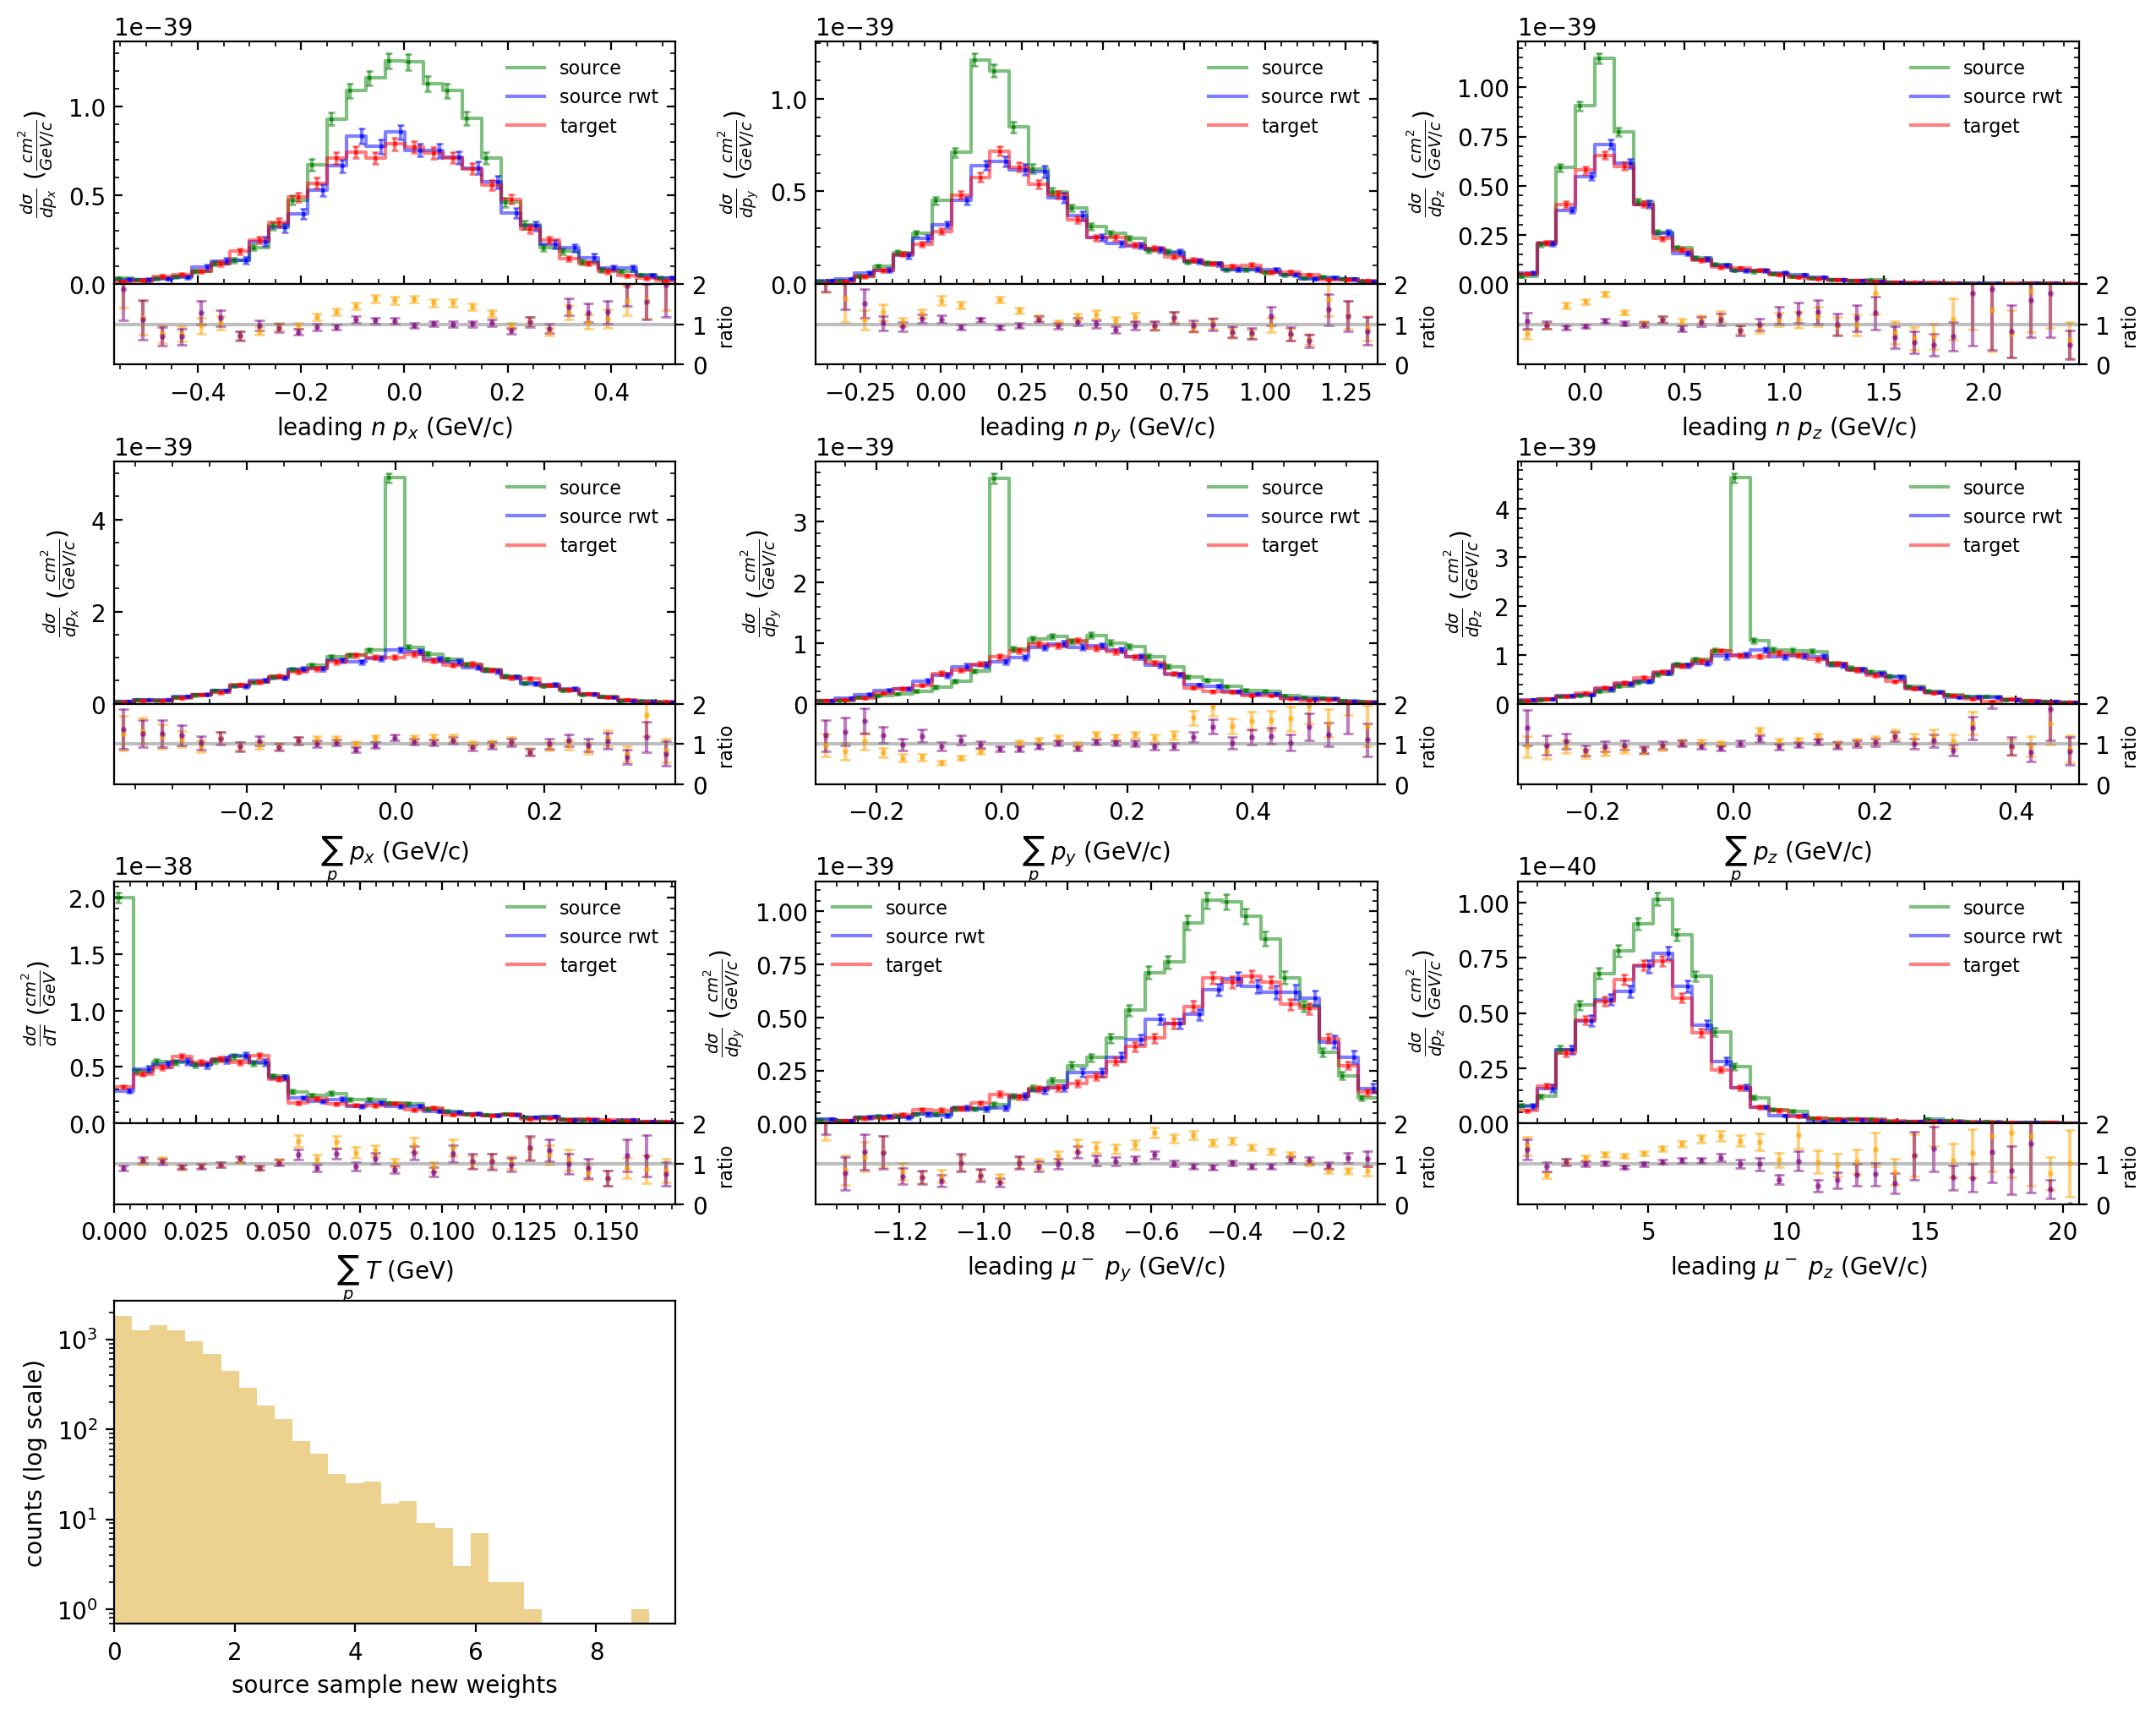

In [8]:
# Set target weights to 1.0 for all events:
target_test[category]['weight'] = 1.0

# Specify variables to be plotted as histograms:
drawing_variables = [
    'leading_neutron_px', 'leading_neutron_py', 'leading_neutron_pz',
    'total_proton_px','total_proton_py','total_proton_pz',
    'total_proton_KE','leading_muon_py','leading_muon_pz', 'weight'
]

# Predict weights for source model:
source_test[category]['weight'] = reweighter.predict_matched_total_weights(
    source_test[category][reweight_variables], 
    original_weight=None,
    target_weight=target_test[category]['weight']
)

# Draw distribution histograms:
draw_source_target_distributions_and_ratio(source_test[category], target_test[category], 
    variables = drawing_variables,
    source_weights = np.ones(len(source_test[category])),
    target_weights = np.ones(len(target_test[category])), 
    new_source_weights = source_test[category]['weight'],
    xlabels = [particle_variable_to_latex(var) for var in drawing_variables],
    ylabels = [diff_xsec_latex_wrt_variable(var) for var in drawing_variables],
    scale_source = scale_source_test, scale_target = scale_target_test
)

# Save reweighter to a path:
reweighter.save_to_pickle(f'/exp/minerva/data/users/zihaolin/BDTReweighters/saved_reweighters_pickle/reweighter_MINERvA_ME_numuCarbon_CCQELike_GENIEv2_to_v3AR23_1mu{category}.pkl')


### CCQE-like 1 $\mu$ 1p0n:

In [9]:
# Category name:
category = '1p0n'

# Specify particle counts in final state:
particle_counts = {'muon':'==1', 'proton':'==1', 'neutron':'==0'}

# List variables to extract from tree:
variable_exprs = [
    'Enu_true', 'Q2', 'q0', 'q3', 'W',
    'dalphat', 'dpt', 'dphit',
    'leading_muon_px', 'leading_muon_py', 'leading_muon_pz', 'leading_muon_KE',
    'total_proton_px', 'total_proton_py', 'total_proton_pz', 'total_proton_KE',
    'leading_proton_px', 'leading_proton_py', 'leading_proton_pz', 'leading_proton_KE',
]

# Specify reweight training variables:
reweight_variables=['leading_proton_px','leading_proton_py','leading_proton_pz','total_proton_KE','leading_muon_py','leading_muon_pz']

# Specify selector_particle's whose momentum are transformed to reaction frame:
# (leading muon px py pz is assumed to be transformed)
particle_names = ['leading_proton','total_proton']

# Create a mask for the topology and create dataframes:
mask = tree_source_train.get_mask_topology(particle_counts = particle_counts, KE_thresholds = KE_thresholds)
source_train[category] = create_dataframe_from_nuisance(tree_source_train, variable_exprs=variable_exprs, mask=mask)

mask = tree_target_train.get_mask_topology(particle_counts = particle_counts, KE_thresholds = KE_thresholds)
target_train[category] = create_dataframe_from_nuisance(tree_target_train, variable_exprs=variable_exprs, mask=mask)

mask = tree_source_test.get_mask_topology(particle_counts = particle_counts, KE_thresholds = KE_thresholds)
source_test[category] = create_dataframe_from_nuisance(tree_source_test, variable_exprs=variable_exprs, mask=mask)

mask = tree_target_test.get_mask_topology(particle_counts = particle_counts, KE_thresholds = KE_thresholds)
target_test[category] = create_dataframe_from_nuisance(tree_target_test, variable_exprs=variable_exprs, mask=mask)


# Convert to reaction frame:
source_train[category] = transform_momentum_to_reaction_frame(source_train[category], selector_lepton='leading_muon', particle_names=particle_names)
target_train[category] = transform_momentum_to_reaction_frame(target_train[category], selector_lepton='leading_muon', particle_names=particle_names)
source_test[category] = transform_momentum_to_reaction_frame(source_test[category], selector_lepton='leading_muon', particle_names=particle_names)
target_test[category] = transform_momentum_to_reaction_frame(target_test[category], selector_lepton='leading_muon', particle_names=particle_names)


# Create a Reweighter (inherited from hep_ml.reweight.GBReweighter) instance: 
reweighter = Reweighter(n_estimators=100, learning_rate=0.1, max_depth=4, min_samples_leaf=30, gb_args={'subsample': 1.0})

# Traing reweighter using source and target sample's reweight variables:
start_time = time.perf_counter()
reweighter.fit(source_train[category][reweight_variables], target_train[category][reweight_variables])
end_time = time.perf_counter()
print(f'Elapsed time: {(end_time-start_time):.3f} sec')


Elapsed time: 24.988 sec


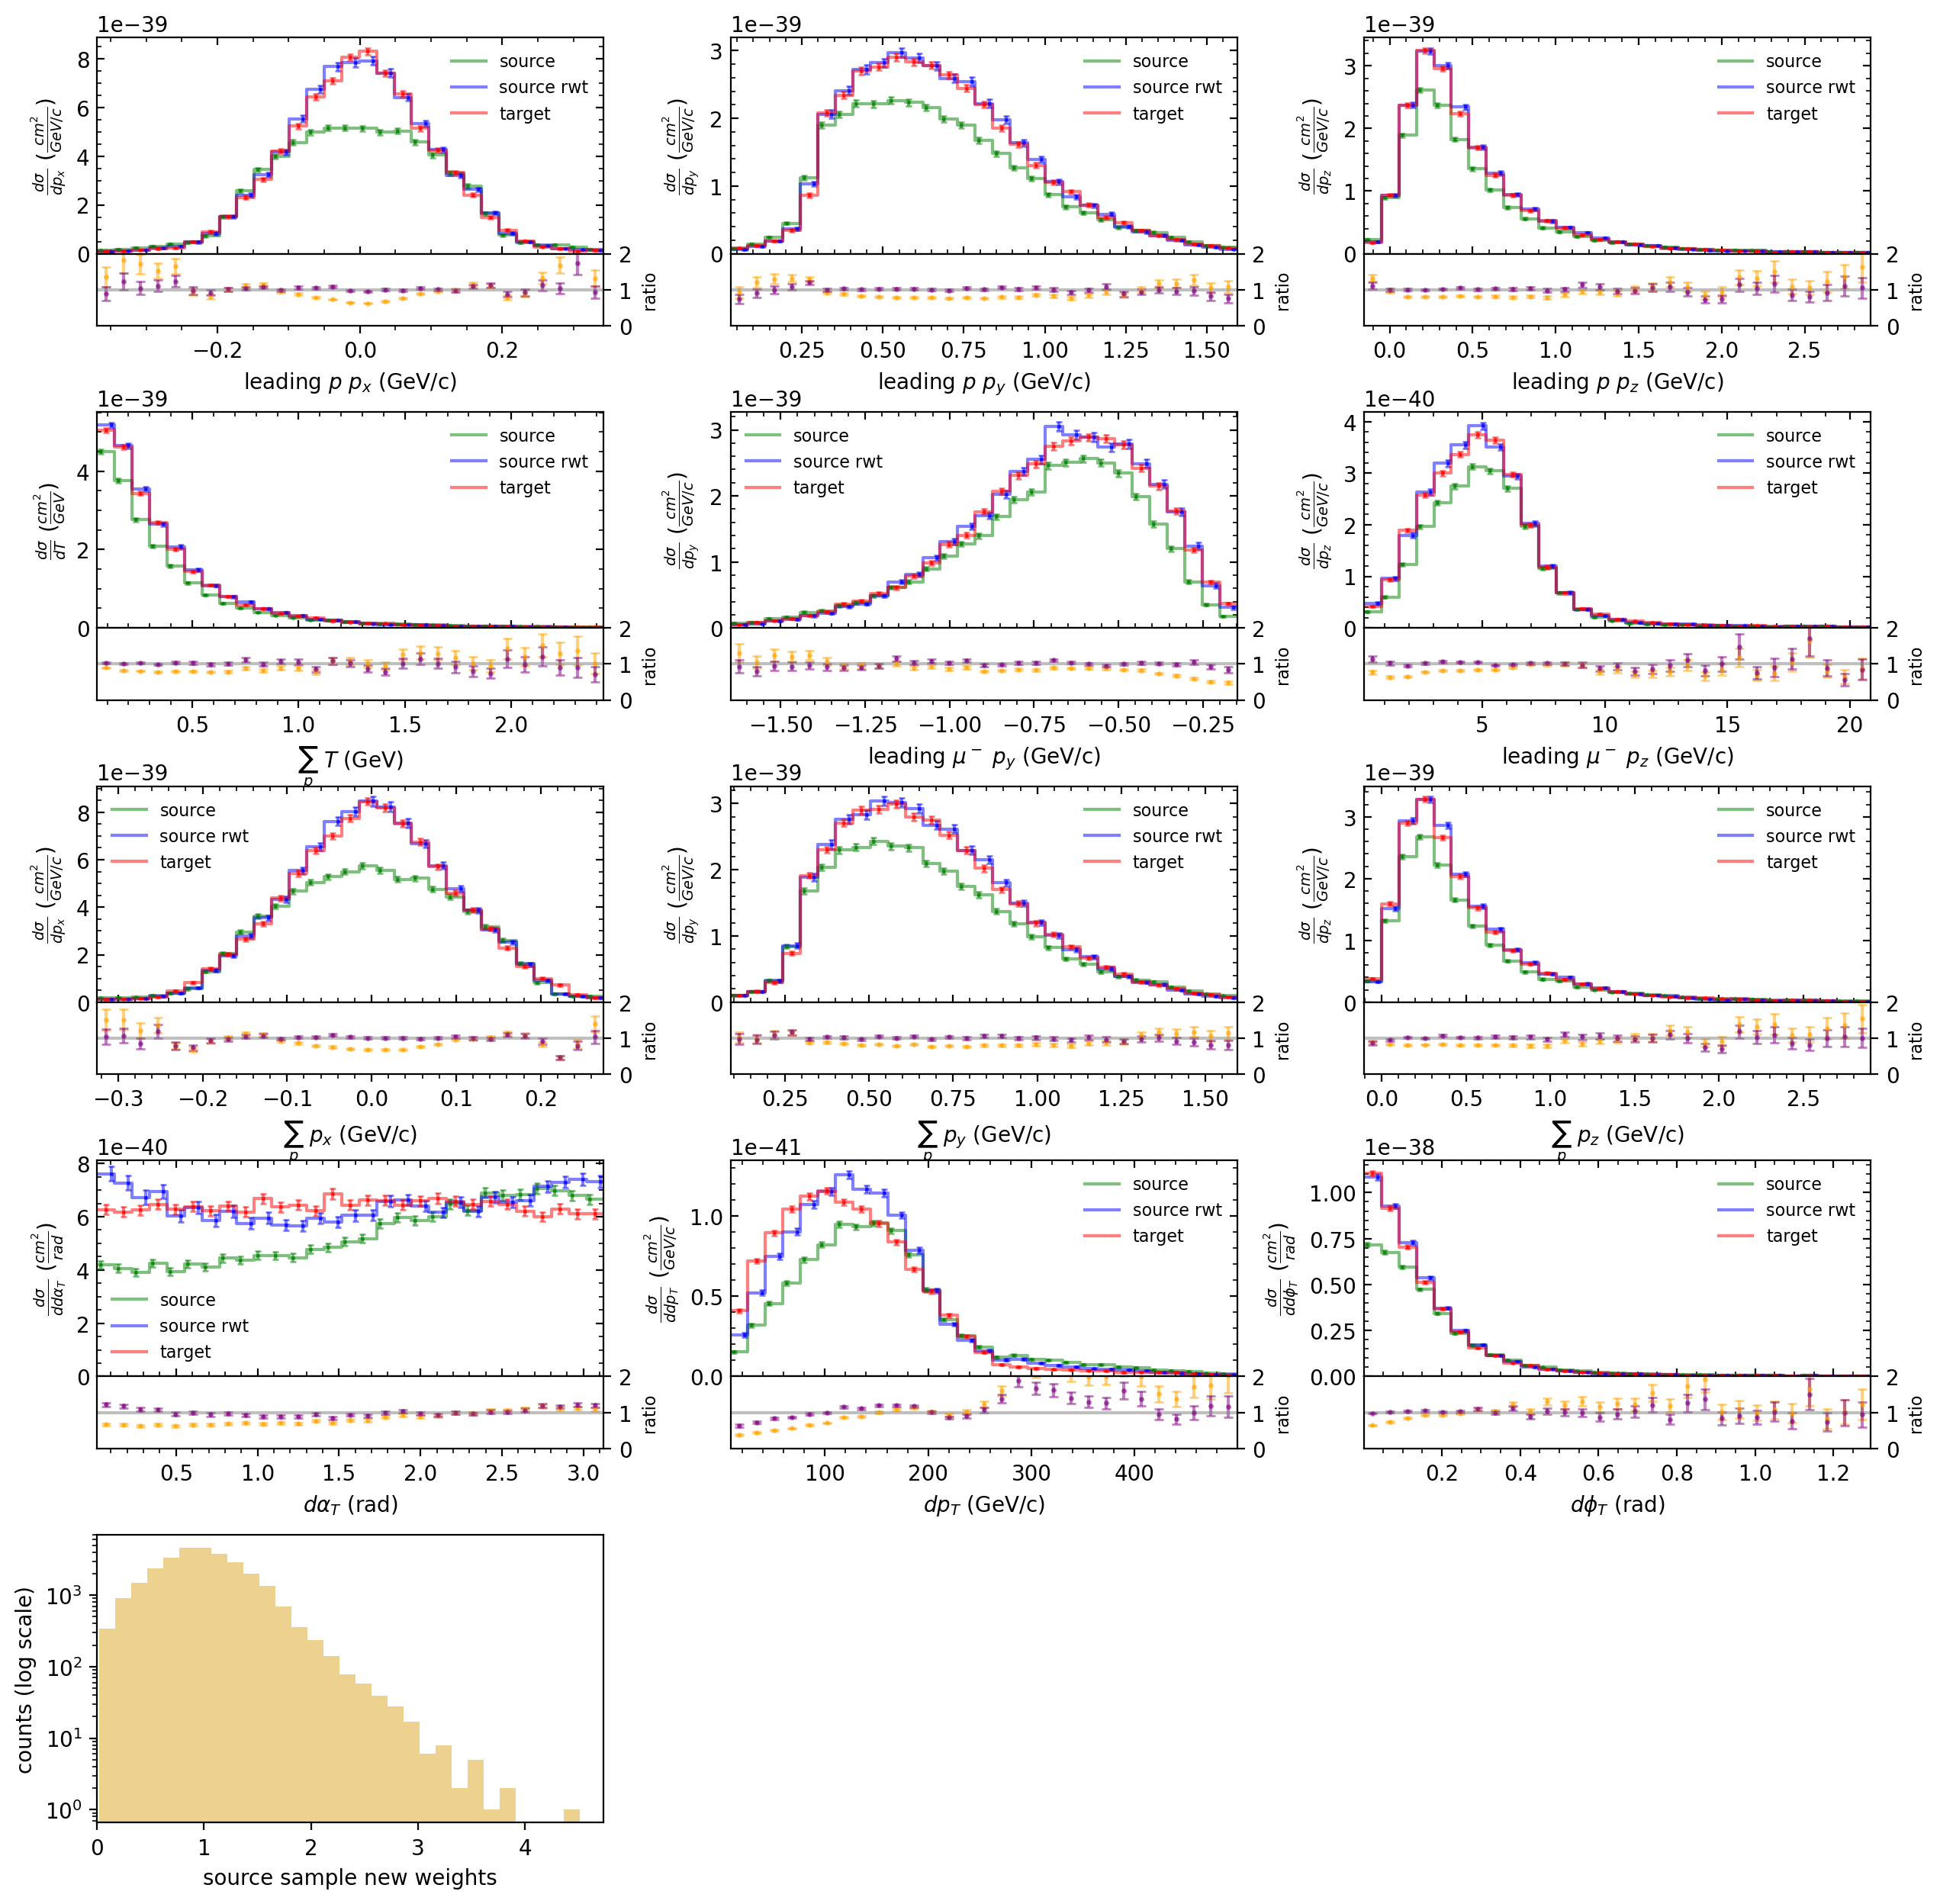

In [10]:
# Set target weights to 1.0 for all events:
target_test[category]['weight'] = 1.0

# Specify variables to be plotted as histograms:
drawing_variables = [
    'leading_proton_px','leading_proton_py','leading_proton_pz',
    'total_proton_KE','leading_muon_py','leading_muon_pz', 
    'total_proton_px','total_proton_py','total_proton_pz', 
    'dalphat', 'dpt', 'dphit', 'weight'
]

# Predict weights for source model:
source_test[category]['weight'] = reweighter.predict_matched_total_weights(
    source_test[category][reweight_variables], 
    original_weight=None,
    target_weight=target_test[category]['weight']
)

# Draw distribution histograms:
draw_source_target_distributions_and_ratio(source_test[category], target_test[category], 
    variables = drawing_variables,
    source_weights = np.ones(len(source_test[category])),
    target_weights = np.ones(len(target_test[category])), 
    new_source_weights = source_test[category]['weight'],
    xlabels = [particle_variable_to_latex(var) for var in drawing_variables],
    ylabels = [diff_xsec_latex_wrt_variable(var) for var in drawing_variables],
    scale_source = scale_source_test, scale_target = scale_target_test
)

# Save reweighter to a path:
reweighter.save_to_pickle(f'/exp/minerva/data/users/zihaolin/BDTReweighters/saved_reweighters_pickle/reweighter_MINERvA_ME_numuCarbon_CCQELike_GENIEv2_to_v3AR23_1mu{category}.pkl')


### CCQE-like 1 $\mu$ 1pNn:

In [11]:
# Category name:
category = '1pNn'

# Specify particle counts in final state:
particle_counts = {'muon':'==1', 'proton':'==1', 'neutron':'>=1'}

# List variables to extract from tree:
variable_exprs = [
    'Enu_true', 'Q2', 'q0', 'q3', 'W',
    'dalphat', 'dpt', 'dphit',
    'leading_muon_px', 'leading_muon_py', 'leading_muon_pz', 'leading_muon_KE',
    'total_proton_px', 'total_proton_py', 'total_proton_pz', 'total_proton_KE',
    'leading_proton_px', 'leading_proton_py', 'leading_proton_pz', 'leading_proton_KE',
    'leading_neutron_px', 'leading_neutron_py', 'leading_neutron_pz', 'leading_neutron_KE',
]

# Specify reweight training variables:
reweight_variables=['leading_proton_px','leading_proton_py','leading_proton_pz','total_proton_KE',
    'leading_muon_py','leading_muon_pz', 'leading_neutron_px', 'leading_neutron_py', 'leading_neutron_pz',]

# Specify selector_particle's whose momentum are transformed to reaction frame:
# (leading muon px py pz is assumed to be transformed)
particle_names = ['leading_proton','leading_neutron','total_proton']

# Create a mask for the topology and create dataframes:
mask = tree_source_train.get_mask_topology(particle_counts = particle_counts, KE_thresholds = KE_thresholds)
source_train[category] = create_dataframe_from_nuisance(tree_source_train, variable_exprs=variable_exprs, mask=mask)

mask = tree_target_train.get_mask_topology(particle_counts = particle_counts, KE_thresholds = KE_thresholds)
target_train[category] = create_dataframe_from_nuisance(tree_target_train, variable_exprs=variable_exprs, mask=mask)

mask = tree_source_test.get_mask_topology(particle_counts = particle_counts, KE_thresholds = KE_thresholds)
source_test[category] = create_dataframe_from_nuisance(tree_source_test, variable_exprs=variable_exprs, mask=mask)

mask = tree_target_test.get_mask_topology(particle_counts = particle_counts, KE_thresholds = KE_thresholds)
target_test[category] = create_dataframe_from_nuisance(tree_target_test, variable_exprs=variable_exprs, mask=mask)


# Convert to reaction frame:
source_train[category] = transform_momentum_to_reaction_frame(source_train[category], selector_lepton='leading_muon', particle_names=particle_names)
target_train[category] = transform_momentum_to_reaction_frame(target_train[category], selector_lepton='leading_muon', particle_names=particle_names)
source_test[category] = transform_momentum_to_reaction_frame(source_test[category], selector_lepton='leading_muon', particle_names=particle_names)
target_test[category] = transform_momentum_to_reaction_frame(target_test[category], selector_lepton='leading_muon', particle_names=particle_names)


# Create a Reweighter (inherited from hep_ml.reweight.GBReweighter) instance: 
reweighter = Reweighter(n_estimators=100, learning_rate=0.1, max_depth=4, min_samples_leaf=30, gb_args={'subsample': 1.0})

# Traing reweighter using source and target sample's reweight variables:
start_time = time.perf_counter()
reweighter.fit(source_train[category][reweight_variables], target_train[category][reweight_variables])
end_time = time.perf_counter()
print(f'Elapsed time: {(end_time-start_time):.3f} sec')


Elapsed time: 18.573 sec


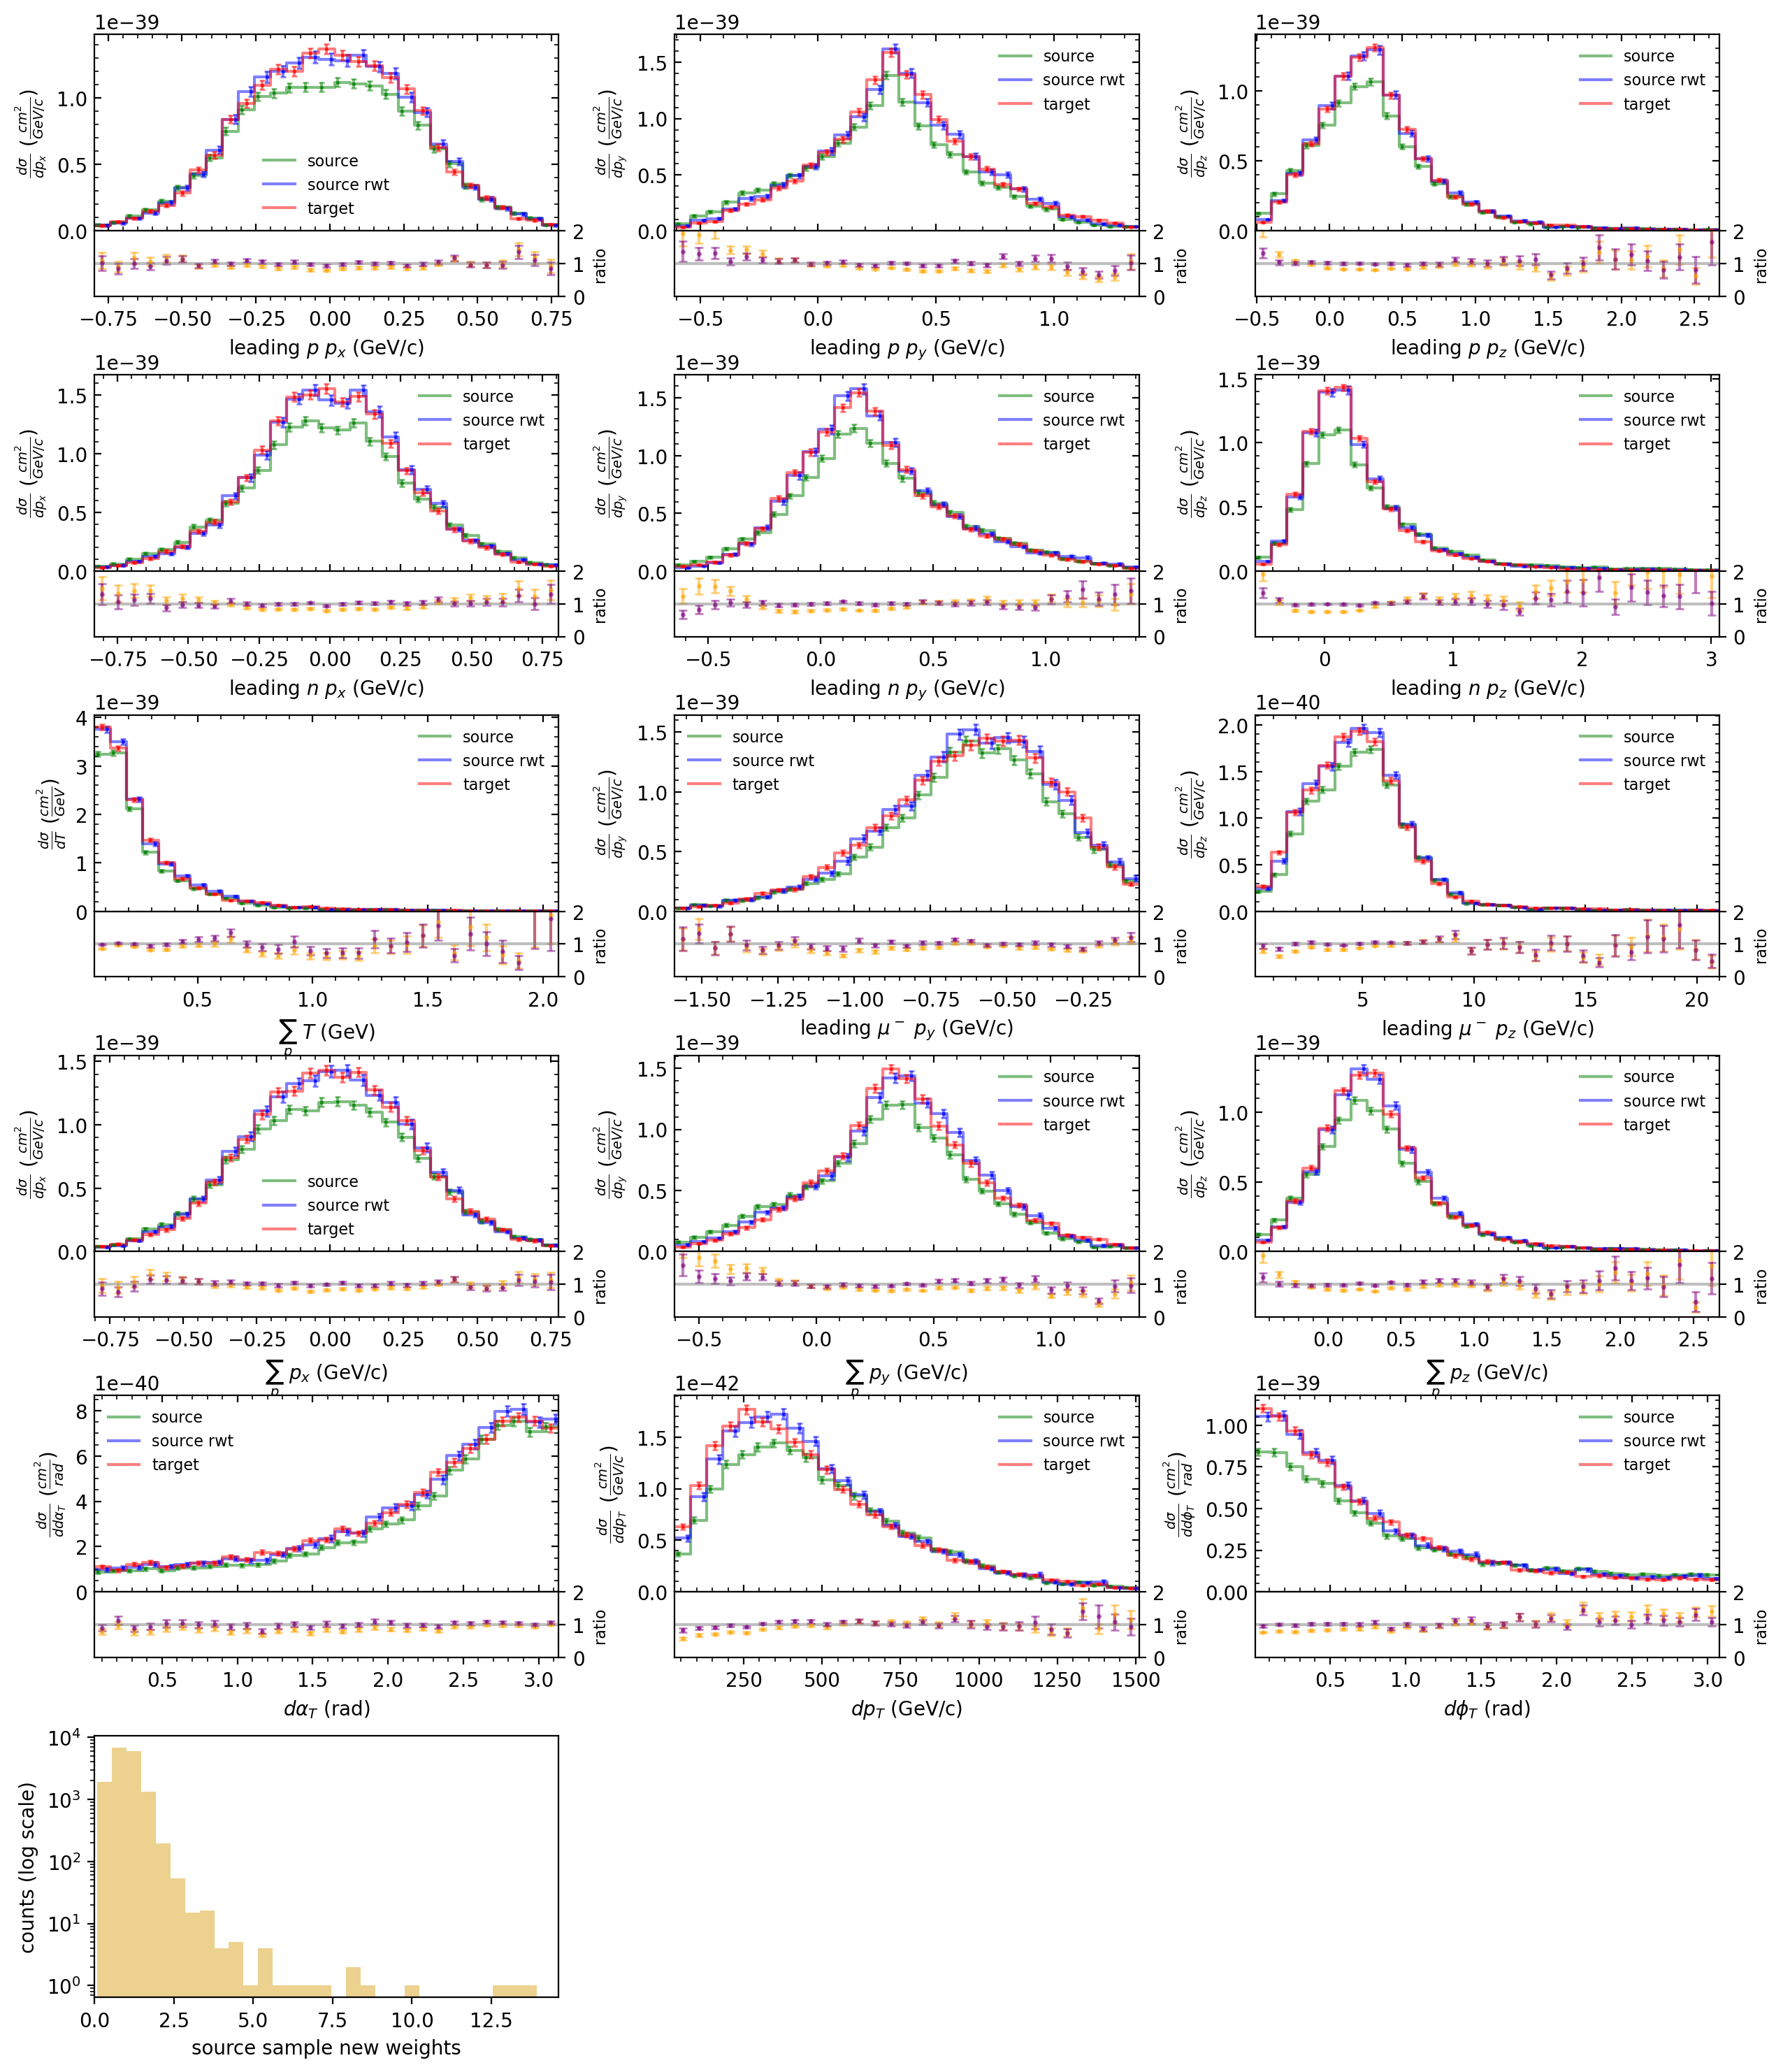

In [12]:
# Set target weights to 1.0 for all events:
target_test[category]['weight'] = 1.0

# Specify variables to be plotted as histograms:
drawing_variables = [
    'leading_proton_px','leading_proton_py','leading_proton_pz',
    'leading_neutron_px','leading_neutron_py','leading_neutron_pz',
    'total_proton_KE','leading_muon_py','leading_muon_pz',
    'total_proton_px','total_proton_py','total_proton_pz',
    'dalphat', 'dpt', 'dphit', 'weight'
]

# Predict weights for source model:
source_test[category]['weight'] = reweighter.predict_matched_total_weights(
    source_test[category][reweight_variables], 
    original_weight=None,
    target_weight=target_test[category]['weight']
)

# Draw distribution histograms:
draw_source_target_distributions_and_ratio(source_test[category], target_test[category], 
    variables = drawing_variables,
    source_weights = np.ones(len(source_test[category])),
    target_weights = np.ones(len(target_test[category])), 
    new_source_weights = source_test[category]['weight'],
    xlabels = [particle_variable_to_latex(var) for var in drawing_variables],
    ylabels = [diff_xsec_latex_wrt_variable(var) for var in drawing_variables],
    scale_source = scale_source_test, scale_target = scale_target_test
)

# Save reweighter to a path:
reweighter.save_to_pickle(f'/exp/minerva/data/users/zihaolin/BDTReweighters/saved_reweighters_pickle/reweighter_MINERvA_ME_numuCarbon_CCQELike_GENIEv2_to_v3AR23_1mu{category}.pkl')


### CCQE-like 1 $\mu$ 2p0n:

In [13]:
# Category name:
category = '2p0n'

# Specify particle counts in final state:
particle_counts = {'muon':'==1', 'proton':'==2', 'neutron':'==0'}

# List variables to extract from tree:
variable_exprs = [
    'Enu_true', 'Q2', 'q0', 'q3', 'W',
    'dalphat', 'dpt', 'dphit',
    'leading_muon_px', 'leading_muon_py', 'leading_muon_pz', 'leading_muon_KE',
    'total_proton_px', 'total_proton_py', 'total_proton_pz', 'total_proton_KE',
    'leading_proton_px', 'leading_proton_py', 'leading_proton_pz', 'leading_proton_KE',
    'subleading_proton_px', 'subleading_proton_py', 'subleading_proton_pz', 'subleading_proton_KE'
]

# Specify reweight training variables:
reweight_variables=['leading_proton_px','leading_proton_py','leading_proton_pz','total_proton_KE',
    'leading_muon_py','leading_muon_pz', 'subleading_proton_px', 'subleading_proton_py', 'subleading_proton_pz',]

# Specify selector_particle's whose momentum are transformed to reaction frame:
# (leading muon px py pz is assumed to be transformed)
particle_names = ['leading_proton','subleading_proton','total_proton']

# Create a mask for the topology and create dataframes:
mask = tree_source_train.get_mask_topology(particle_counts = particle_counts, KE_thresholds = KE_thresholds)
source_train[category] = create_dataframe_from_nuisance(tree_source_train, variable_exprs=variable_exprs, mask=mask)

mask = tree_target_train.get_mask_topology(particle_counts = particle_counts, KE_thresholds = KE_thresholds)
target_train[category] = create_dataframe_from_nuisance(tree_target_train, variable_exprs=variable_exprs, mask=mask)

mask = tree_source_test.get_mask_topology(particle_counts = particle_counts, KE_thresholds = KE_thresholds)
source_test[category] = create_dataframe_from_nuisance(tree_source_test, variable_exprs=variable_exprs, mask=mask)

mask = tree_target_test.get_mask_topology(particle_counts = particle_counts, KE_thresholds = KE_thresholds)
target_test[category] = create_dataframe_from_nuisance(tree_target_test, variable_exprs=variable_exprs, mask=mask)


# Convert to reaction frame:
source_train[category] = transform_momentum_to_reaction_frame(source_train[category], selector_lepton='leading_muon', particle_names=particle_names)
target_train[category] = transform_momentum_to_reaction_frame(target_train[category], selector_lepton='leading_muon', particle_names=particle_names)
source_test[category] = transform_momentum_to_reaction_frame(source_test[category], selector_lepton='leading_muon', particle_names=particle_names)
target_test[category] = transform_momentum_to_reaction_frame(target_test[category], selector_lepton='leading_muon', particle_names=particle_names)


# Create a Reweighter (inherited from hep_ml.reweight.GBReweighter) instance: 
reweighter = Reweighter(n_estimators=30, learning_rate=0.1, max_depth=3, min_samples_leaf=30, gb_args={'subsample': 1.0})

# Traing reweighter using source and target sample's reweight variables:
start_time = time.perf_counter()
reweighter.fit(source_train[category][reweight_variables], target_train[category][reweight_variables])
end_time = time.perf_counter()
print(f'Elapsed time: {(end_time-start_time):.3f} sec')


Elapsed time: 2.096 sec


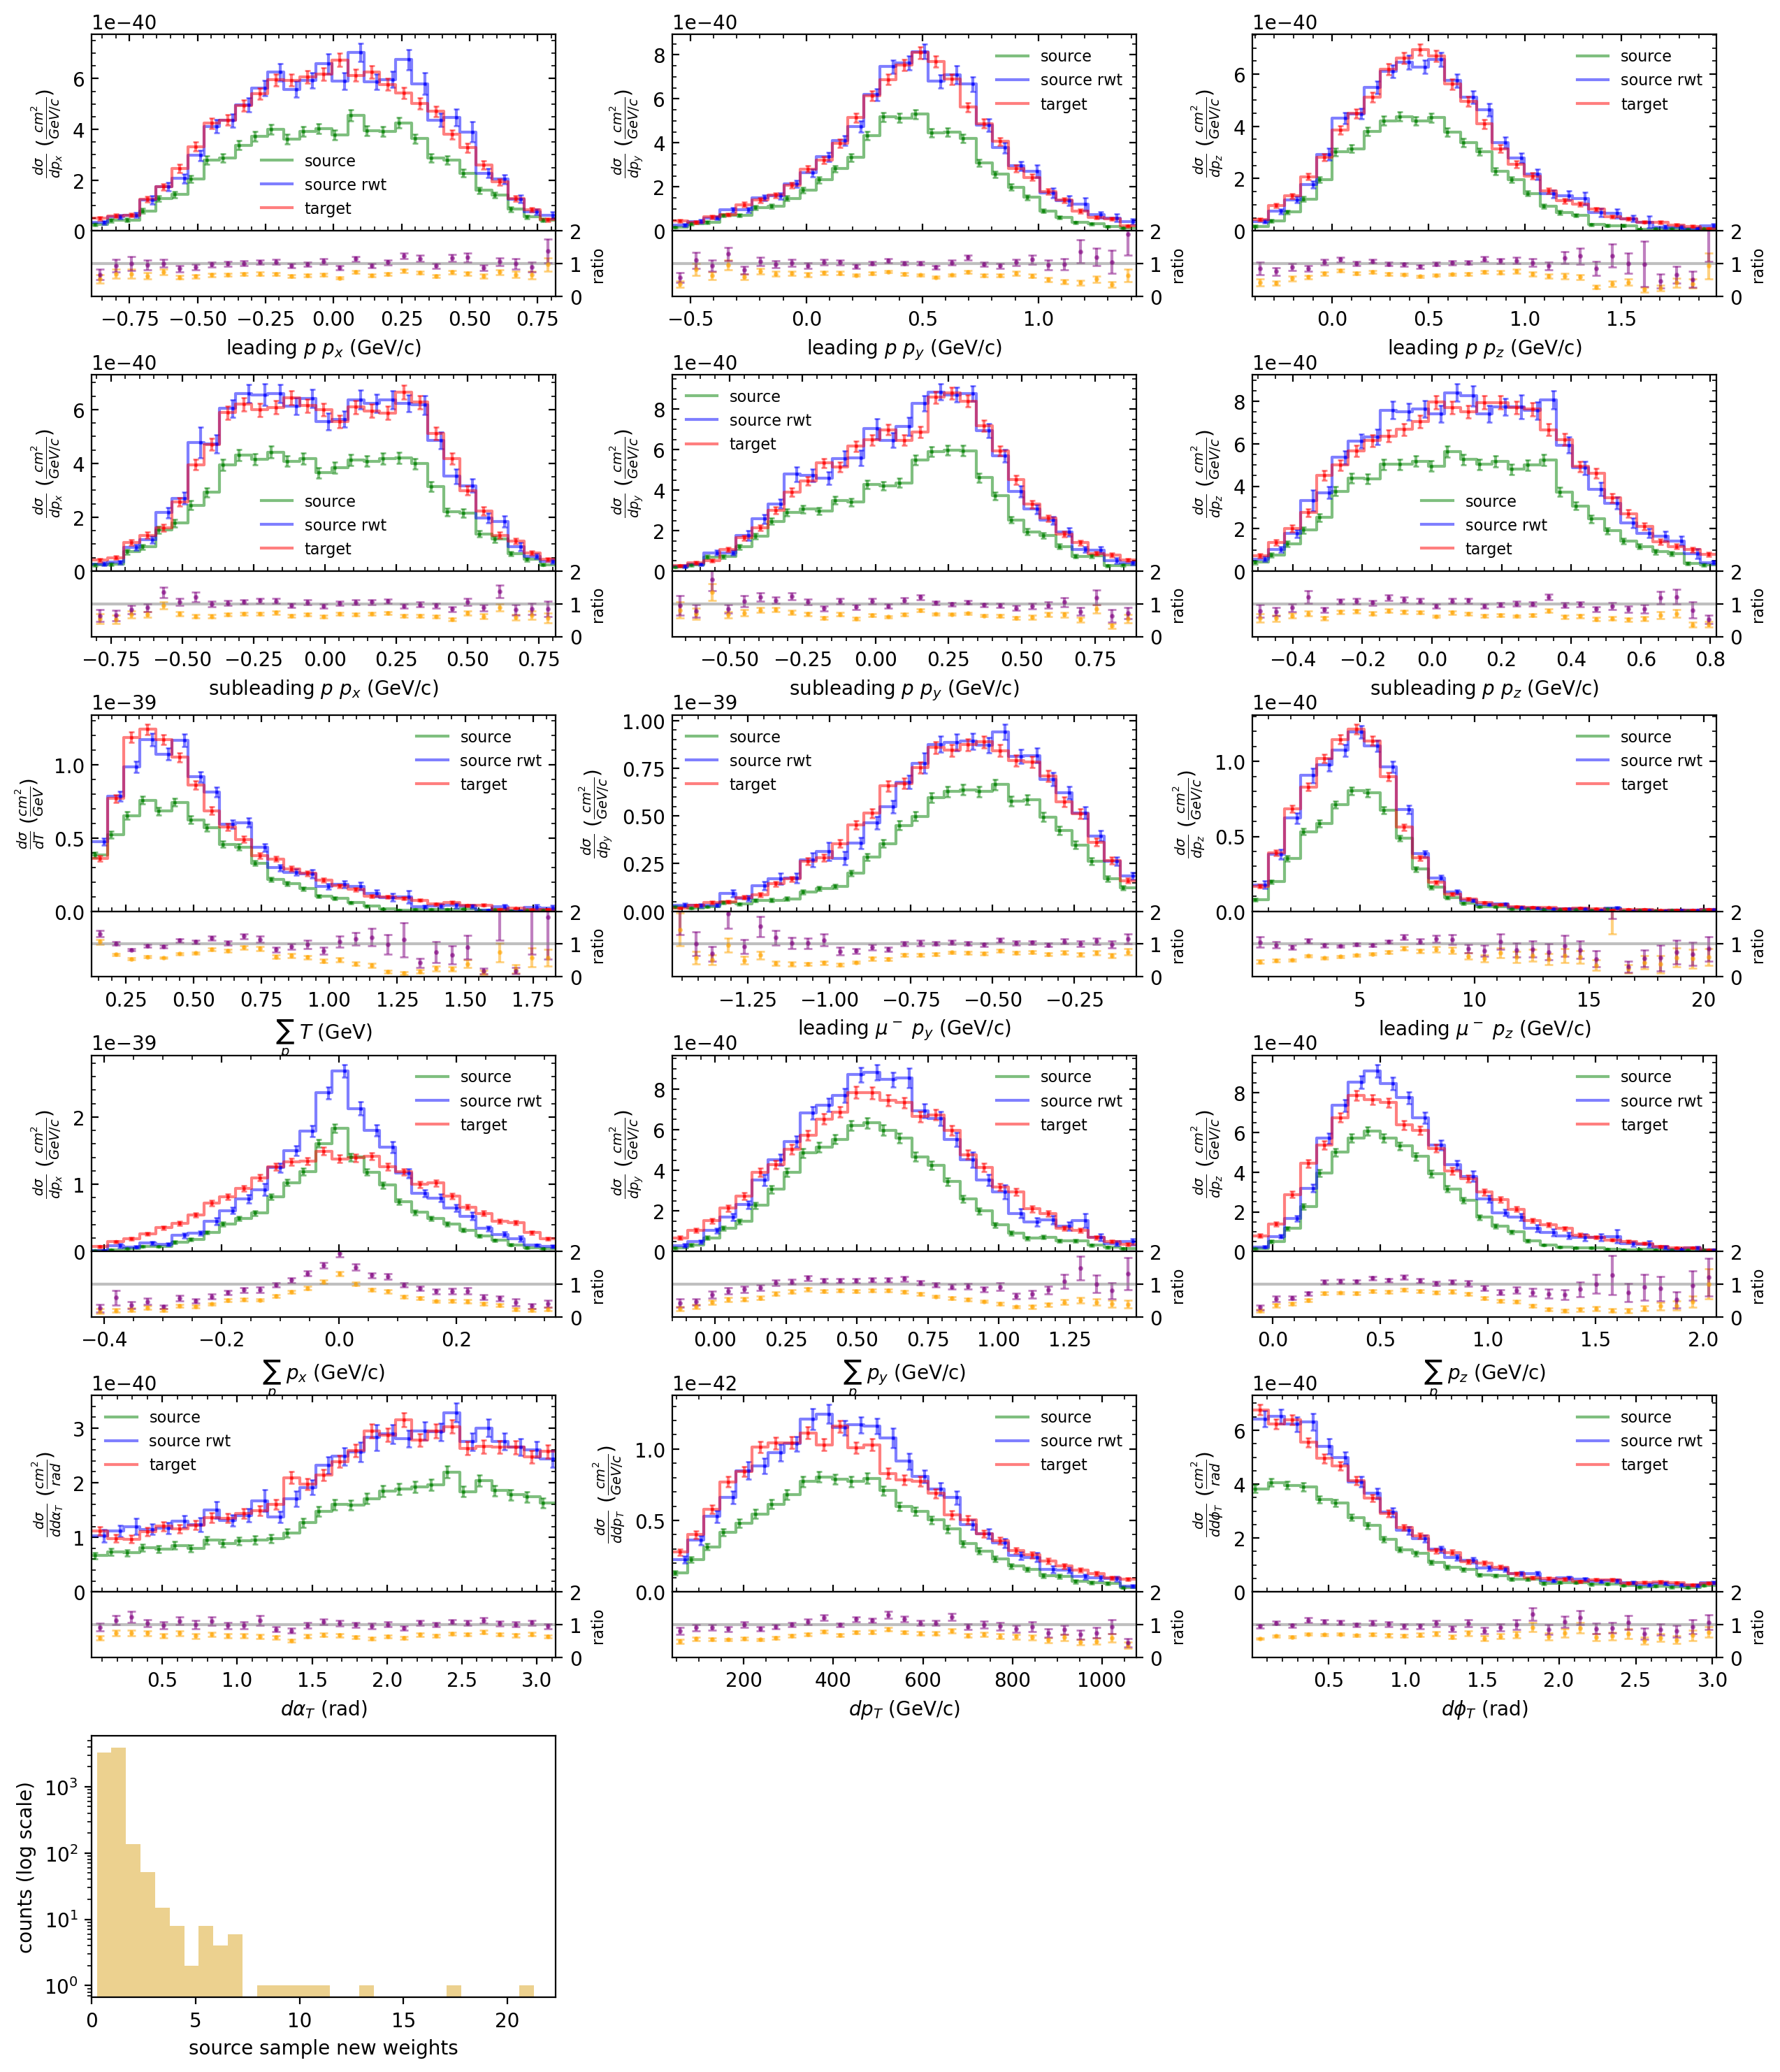

In [14]:
# Set target weights to 1.0 for all events:
target_test[category]['weight'] = 1.0

# Specify variables to be plotted as histograms:
drawing_variables = [
    'leading_proton_px','leading_proton_py','leading_proton_pz',
    'subleading_proton_px','subleading_proton_py','subleading_proton_pz',
    'total_proton_KE','leading_muon_py','leading_muon_pz', 
    'total_proton_px','total_proton_py','total_proton_pz', 
    'dalphat', 'dpt', 'dphit', 'weight'
]

# Predict weights for source model:
source_test[category]['weight'] = reweighter.predict_matched_total_weights(
    source_test[category][reweight_variables], 
    original_weight=None,
    target_weight=target_test[category]['weight']
)

# Draw distribution histograms:
draw_source_target_distributions_and_ratio(source_test[category], target_test[category], 
    variables = drawing_variables,
    source_weights = np.ones(len(source_test[category])),
    target_weights = np.ones(len(target_test[category])), 
    new_source_weights = source_test[category]['weight'],
    xlabels = [particle_variable_to_latex(var) for var in drawing_variables],
    ylabels = [diff_xsec_latex_wrt_variable(var) for var in drawing_variables],
    scale_source = scale_source_test, scale_target = scale_target_test
)

# Save reweighter to a path:
reweighter.save_to_pickle(f'/exp/minerva/data/users/zihaolin/BDTReweighters/saved_reweighters_pickle/reweighter_MINERvA_ME_numuCarbon_CCQELike_GENIEv2_to_v3AR23_1mu{category}.pkl')


### CCQE-like 1 $\mu$ 2pNn:

In [15]:
# Category name:
category = '2pNn'

# Specify particle counts in final state:
particle_counts = {'muon':'==1', 'proton':'==2', 'neutron':'>=1'}

# List variables to extract from tree:
variable_exprs = [
    'Enu_true', 'Q2', 'q0', 'q3', 'W',
    'dalphat', 'dpt', 'dphit',
    'leading_muon_px', 'leading_muon_py', 'leading_muon_pz', 'leading_muon_KE',
    'total_proton_px', 'total_proton_py', 'total_proton_pz', 'total_proton_KE',
    'leading_proton_px', 'leading_proton_py', 'leading_proton_pz', 'leading_proton_KE',
    'subleading_proton_px', 'subleading_proton_py', 'subleading_proton_pz', 'subleading_proton_KE',
    'leading_neutron_px', 'leading_neutron_py', 'leading_neutron_pz', 'leading_neutron_KE'
]

# Specify reweight training variables:
reweight_variables=['leading_proton_px','leading_proton_py','leading_proton_pz','total_proton_KE',
    'leading_neutron_px', 'leading_neutron_py', 'leading_neutron_pz',
    'leading_muon_py','leading_muon_pz', 'subleading_proton_px', 'subleading_proton_py', 'subleading_proton_pz',]

# Specify selector_particle's whose momentum are transformed to reaction frame:
# (leading muon px py pz is assumed to be transformed)
particle_names = ['leading_proton','subleading_proton','leading_neutron','total_proton']

# Create a mask for the topology and create dataframes:
mask = tree_source_train.get_mask_topology(particle_counts = particle_counts, KE_thresholds = KE_thresholds)
source_train[category] = create_dataframe_from_nuisance(tree_source_train, variable_exprs=variable_exprs, mask=mask)

mask = tree_target_train.get_mask_topology(particle_counts = particle_counts, KE_thresholds = KE_thresholds)
target_train[category] = create_dataframe_from_nuisance(tree_target_train, variable_exprs=variable_exprs, mask=mask)

mask = tree_source_test.get_mask_topology(particle_counts = particle_counts, KE_thresholds = KE_thresholds)
source_test[category] = create_dataframe_from_nuisance(tree_source_test, variable_exprs=variable_exprs, mask=mask)

mask = tree_target_test.get_mask_topology(particle_counts = particle_counts, KE_thresholds = KE_thresholds)
target_test[category] = create_dataframe_from_nuisance(tree_target_test, variable_exprs=variable_exprs, mask=mask)


# Convert to reaction frame:
source_train[category] = transform_momentum_to_reaction_frame(source_train[category], selector_lepton='leading_muon', particle_names=particle_names)
target_train[category] = transform_momentum_to_reaction_frame(target_train[category], selector_lepton='leading_muon', particle_names=particle_names)
source_test[category] = transform_momentum_to_reaction_frame(source_test[category], selector_lepton='leading_muon', particle_names=particle_names)
target_test[category] = transform_momentum_to_reaction_frame(target_test[category], selector_lepton='leading_muon', particle_names=particle_names)


# Create a Reweighter (inherited from hep_ml.reweight.GBReweighter) instance: 
reweighter = Reweighter(n_estimators=100, learning_rate=0.1, max_depth=4, min_samples_leaf=30, gb_args={'subsample': 1.0})

# Traing reweighter using source and target sample's reweight variables:
start_time = time.perf_counter()
reweighter.fit(source_train[category][reweight_variables], target_train[category][reweight_variables])
end_time = time.perf_counter()
print(f'Elapsed time: {(end_time-start_time):.3f} sec')


Elapsed time: 16.816 sec


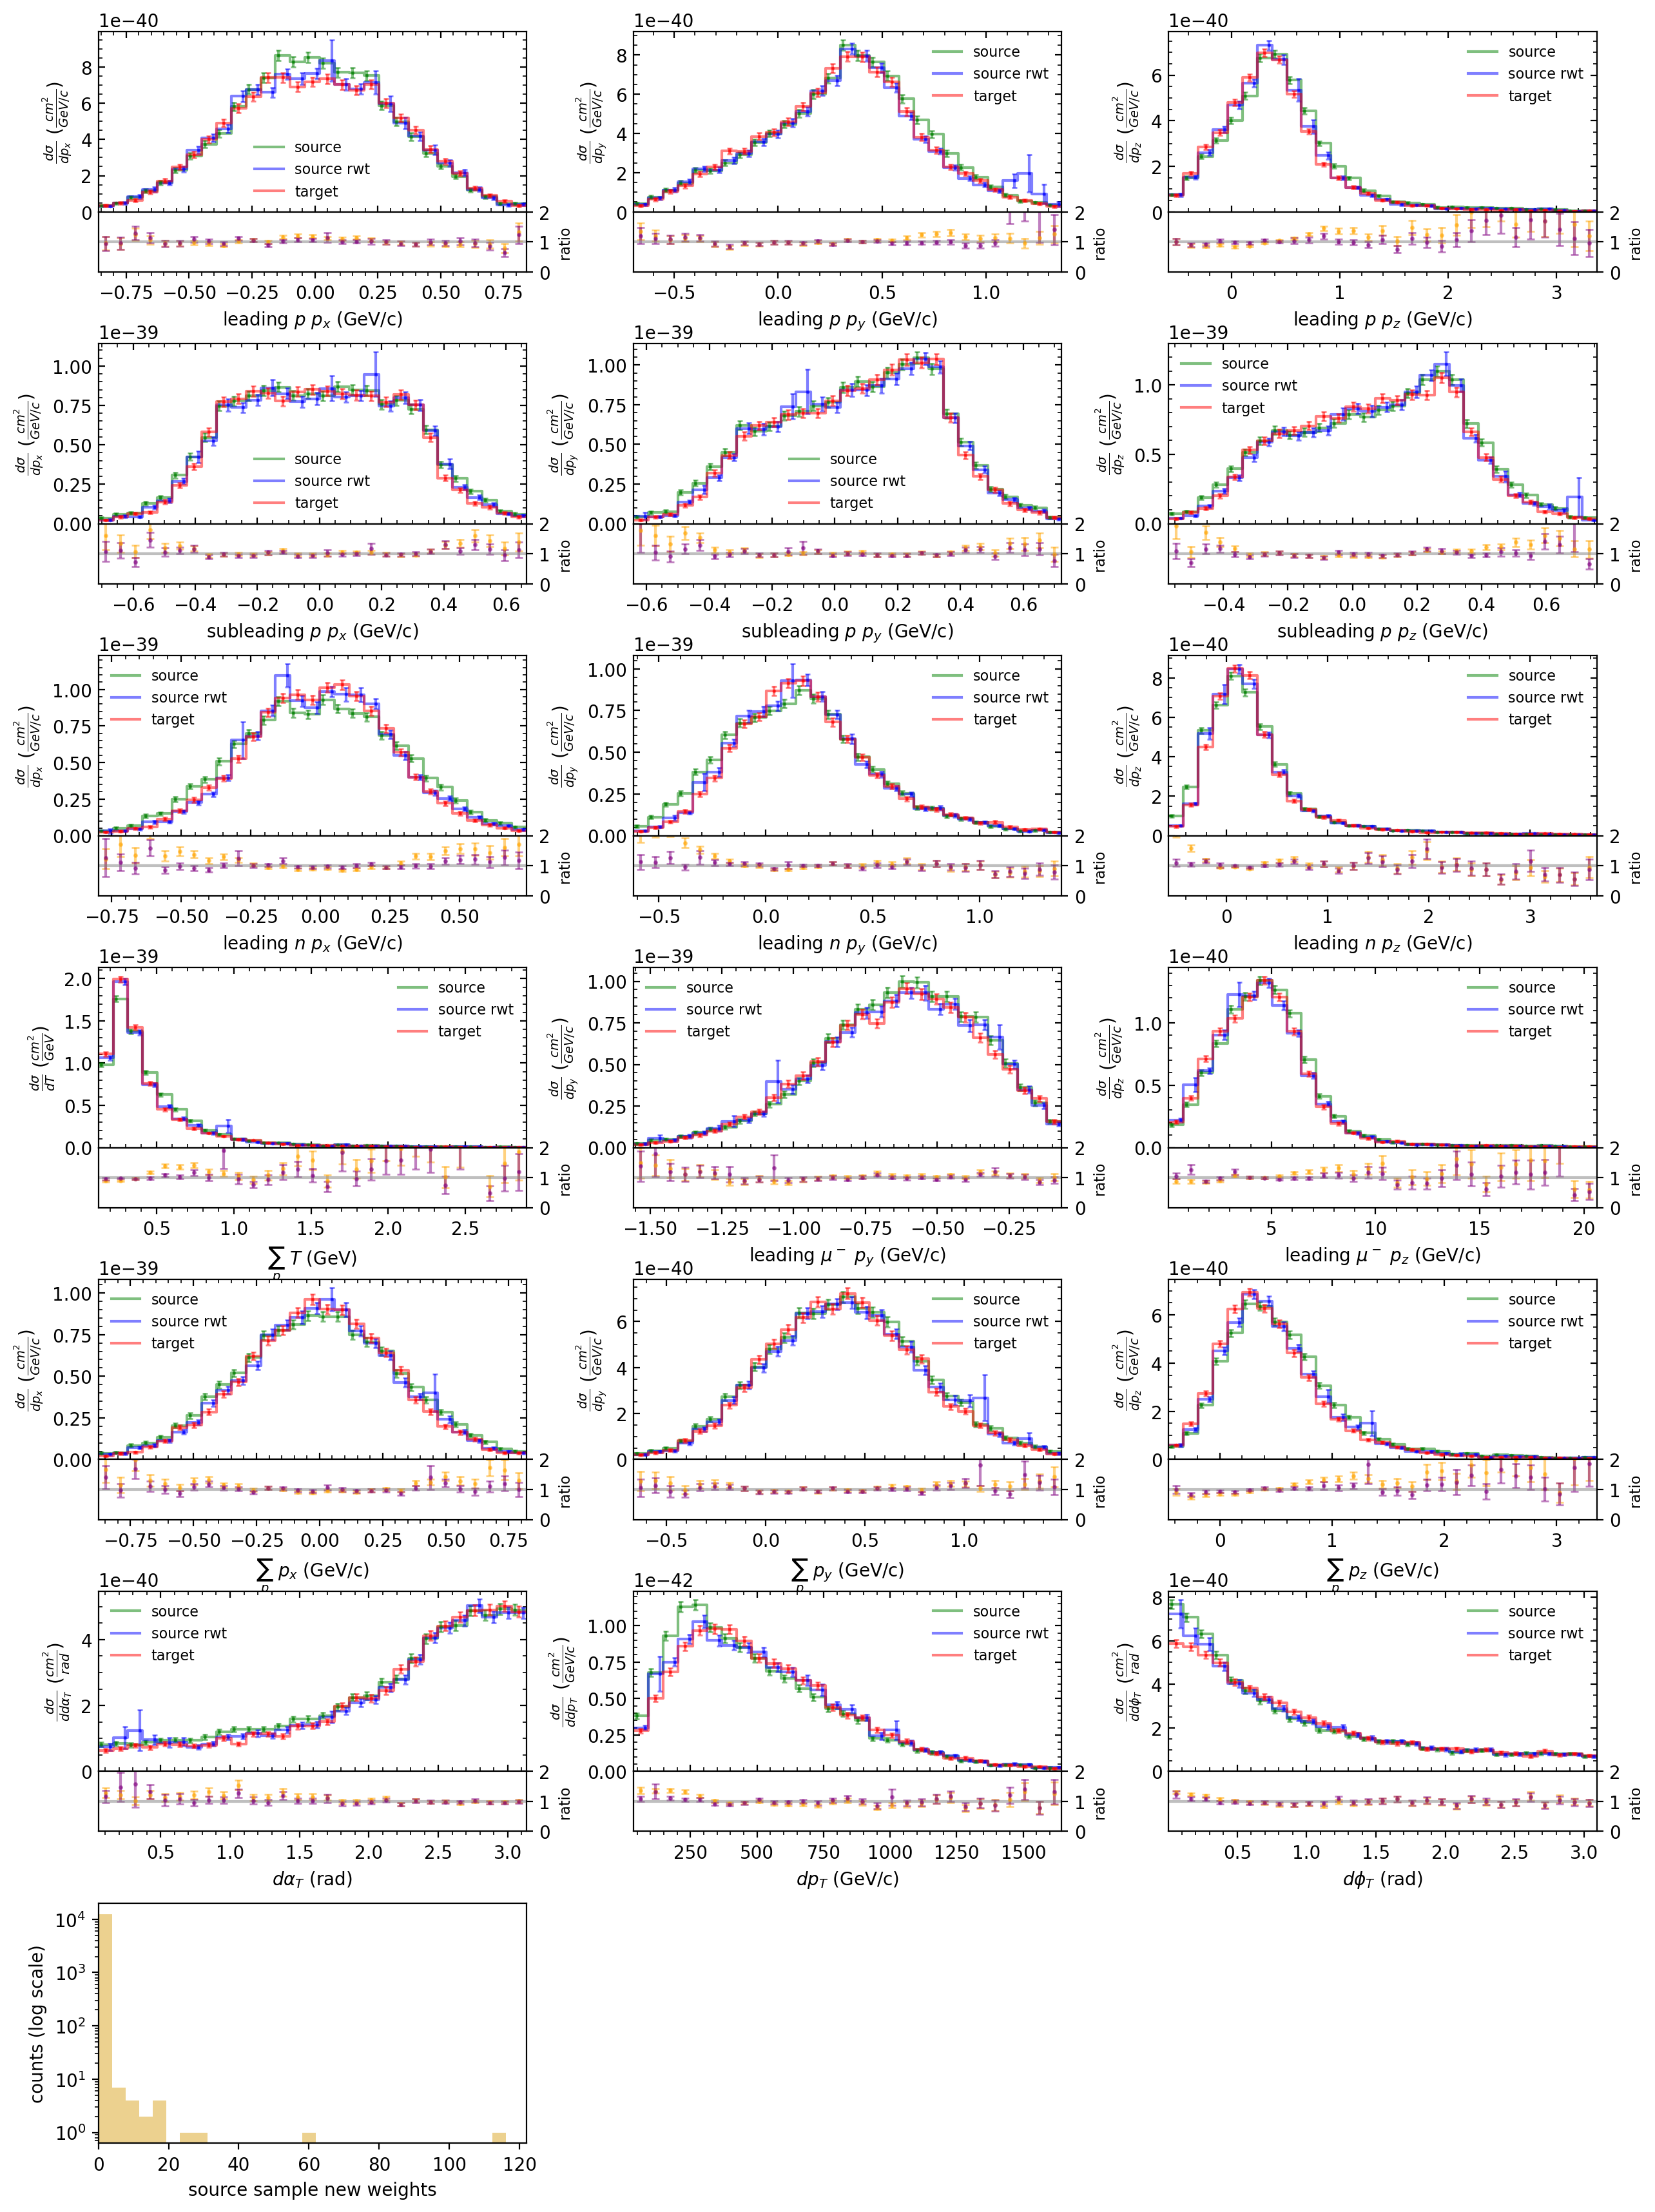

In [16]:
# Set target weights to 1.0 for all events:
target_test[category]['weight'] = 1.0

# Specify variables to be plotted as histograms:
drawing_variables = [
    'leading_proton_px','leading_proton_py','leading_proton_pz',
    'subleading_proton_px','subleading_proton_py','subleading_proton_pz',
    'leading_neutron_px', 'leading_neutron_py', 'leading_neutron_pz',
    'total_proton_KE','leading_muon_py','leading_muon_pz',
    'total_proton_px','total_proton_py','total_proton_pz',
    'dalphat', 'dpt', 'dphit', 'weight'
]

# Predict weights for source model:
source_test[category]['weight'] = reweighter.predict_matched_total_weights(
    source_test[category][reweight_variables], 
    original_weight=None,
    target_weight=target_test[category]['weight']
)

# Draw distribution histograms:
draw_source_target_distributions_and_ratio(source_test[category], target_test[category], 
    variables = drawing_variables,
    source_weights = np.ones(len(source_test[category])),
    target_weights = np.ones(len(target_test[category])), 
    new_source_weights = source_test[category]['weight'],
    xlabels = [particle_variable_to_latex(var) for var in drawing_variables],
    ylabels = [diff_xsec_latex_wrt_variable(var) for var in drawing_variables],
    scale_source = scale_source_test, scale_target = scale_target_test
)

# Save reweighter to a path:
reweighter.save_to_pickle(f'/exp/minerva/data/users/zihaolin/BDTReweighters/saved_reweighters_pickle/reweighter_MINERvA_ME_numuCarbon_CCQELike_GENIEv2_to_v3AR23_1mu{category}.pkl')


### CCQE-like 1 $\mu$ others ($\ge$ 3 protons):

In [17]:
# Category name:
category = 'others'

# Specify particle counts in final state:
particle_counts = {'muon':'==1', 'proton':'>=3'}

# List variables to extract from tree:
variable_exprs = [
    'Enu_true', 'Q2', 'q0', 'q3', 'W',
    'dalphat', 'dpt', 'dphit',
    'leading_muon_px', 'leading_muon_py', 'leading_muon_pz', 'leading_muon_KE',
    'total_proton_px', 'total_proton_py', 'total_proton_pz', 'total_proton_KE',
    'leading_proton_px', 'leading_proton_py', 'leading_proton_pz', 'leading_proton_KE',
]

# Specify reweight training variables:
reweight_variables=['leading_proton_px','leading_proton_py','leading_proton_pz','total_proton_KE',
    'leading_muon_py','leading_muon_pz']

# Specify selector_particle's whose momentum are transformed to reaction frame:
# (leading muon px py pz is assumed to be transformed)
particle_names = ['leading_proton','total_proton']

# Create a mask for the topology and create dataframes:
mask = tree_source_train.get_mask_topology(particle_counts = particle_counts, KE_thresholds = KE_thresholds)
source_train[category] = create_dataframe_from_nuisance(tree_source_train, variable_exprs=variable_exprs, mask=mask)

mask = tree_target_train.get_mask_topology(particle_counts = particle_counts, KE_thresholds = KE_thresholds)
target_train[category] = create_dataframe_from_nuisance(tree_target_train, variable_exprs=variable_exprs, mask=mask)

mask = tree_source_test.get_mask_topology(particle_counts = particle_counts, KE_thresholds = KE_thresholds)
source_test[category] = create_dataframe_from_nuisance(tree_source_test, variable_exprs=variable_exprs, mask=mask)

mask = tree_target_test.get_mask_topology(particle_counts = particle_counts, KE_thresholds = KE_thresholds)
target_test[category] = create_dataframe_from_nuisance(tree_target_test, variable_exprs=variable_exprs, mask=mask)


# Convert to reaction frame:
source_train[category] = transform_momentum_to_reaction_frame(source_train[category], selector_lepton='leading_muon', particle_names=particle_names)
target_train[category] = transform_momentum_to_reaction_frame(target_train[category], selector_lepton='leading_muon', particle_names=particle_names)
source_test[category] = transform_momentum_to_reaction_frame(source_test[category], selector_lepton='leading_muon', particle_names=particle_names)
target_test[category] = transform_momentum_to_reaction_frame(target_test[category], selector_lepton='leading_muon', particle_names=particle_names)


# Create a Reweighter (inherited from hep_ml.reweight.GBReweighter) instance: 
reweighter = Reweighter(n_estimators=100, learning_rate=0.1, max_depth=4, min_samples_leaf=30, gb_args={'subsample': 1.0})

# Traing reweighter using source and target sample's reweight variables:
start_time = time.perf_counter()
reweighter.fit(source_train[category][reweight_variables], target_train[category][reweight_variables])
end_time = time.perf_counter()
print(f'Elapsed time: {(end_time-start_time):.3f} sec')



Elapsed time: 11.945 sec


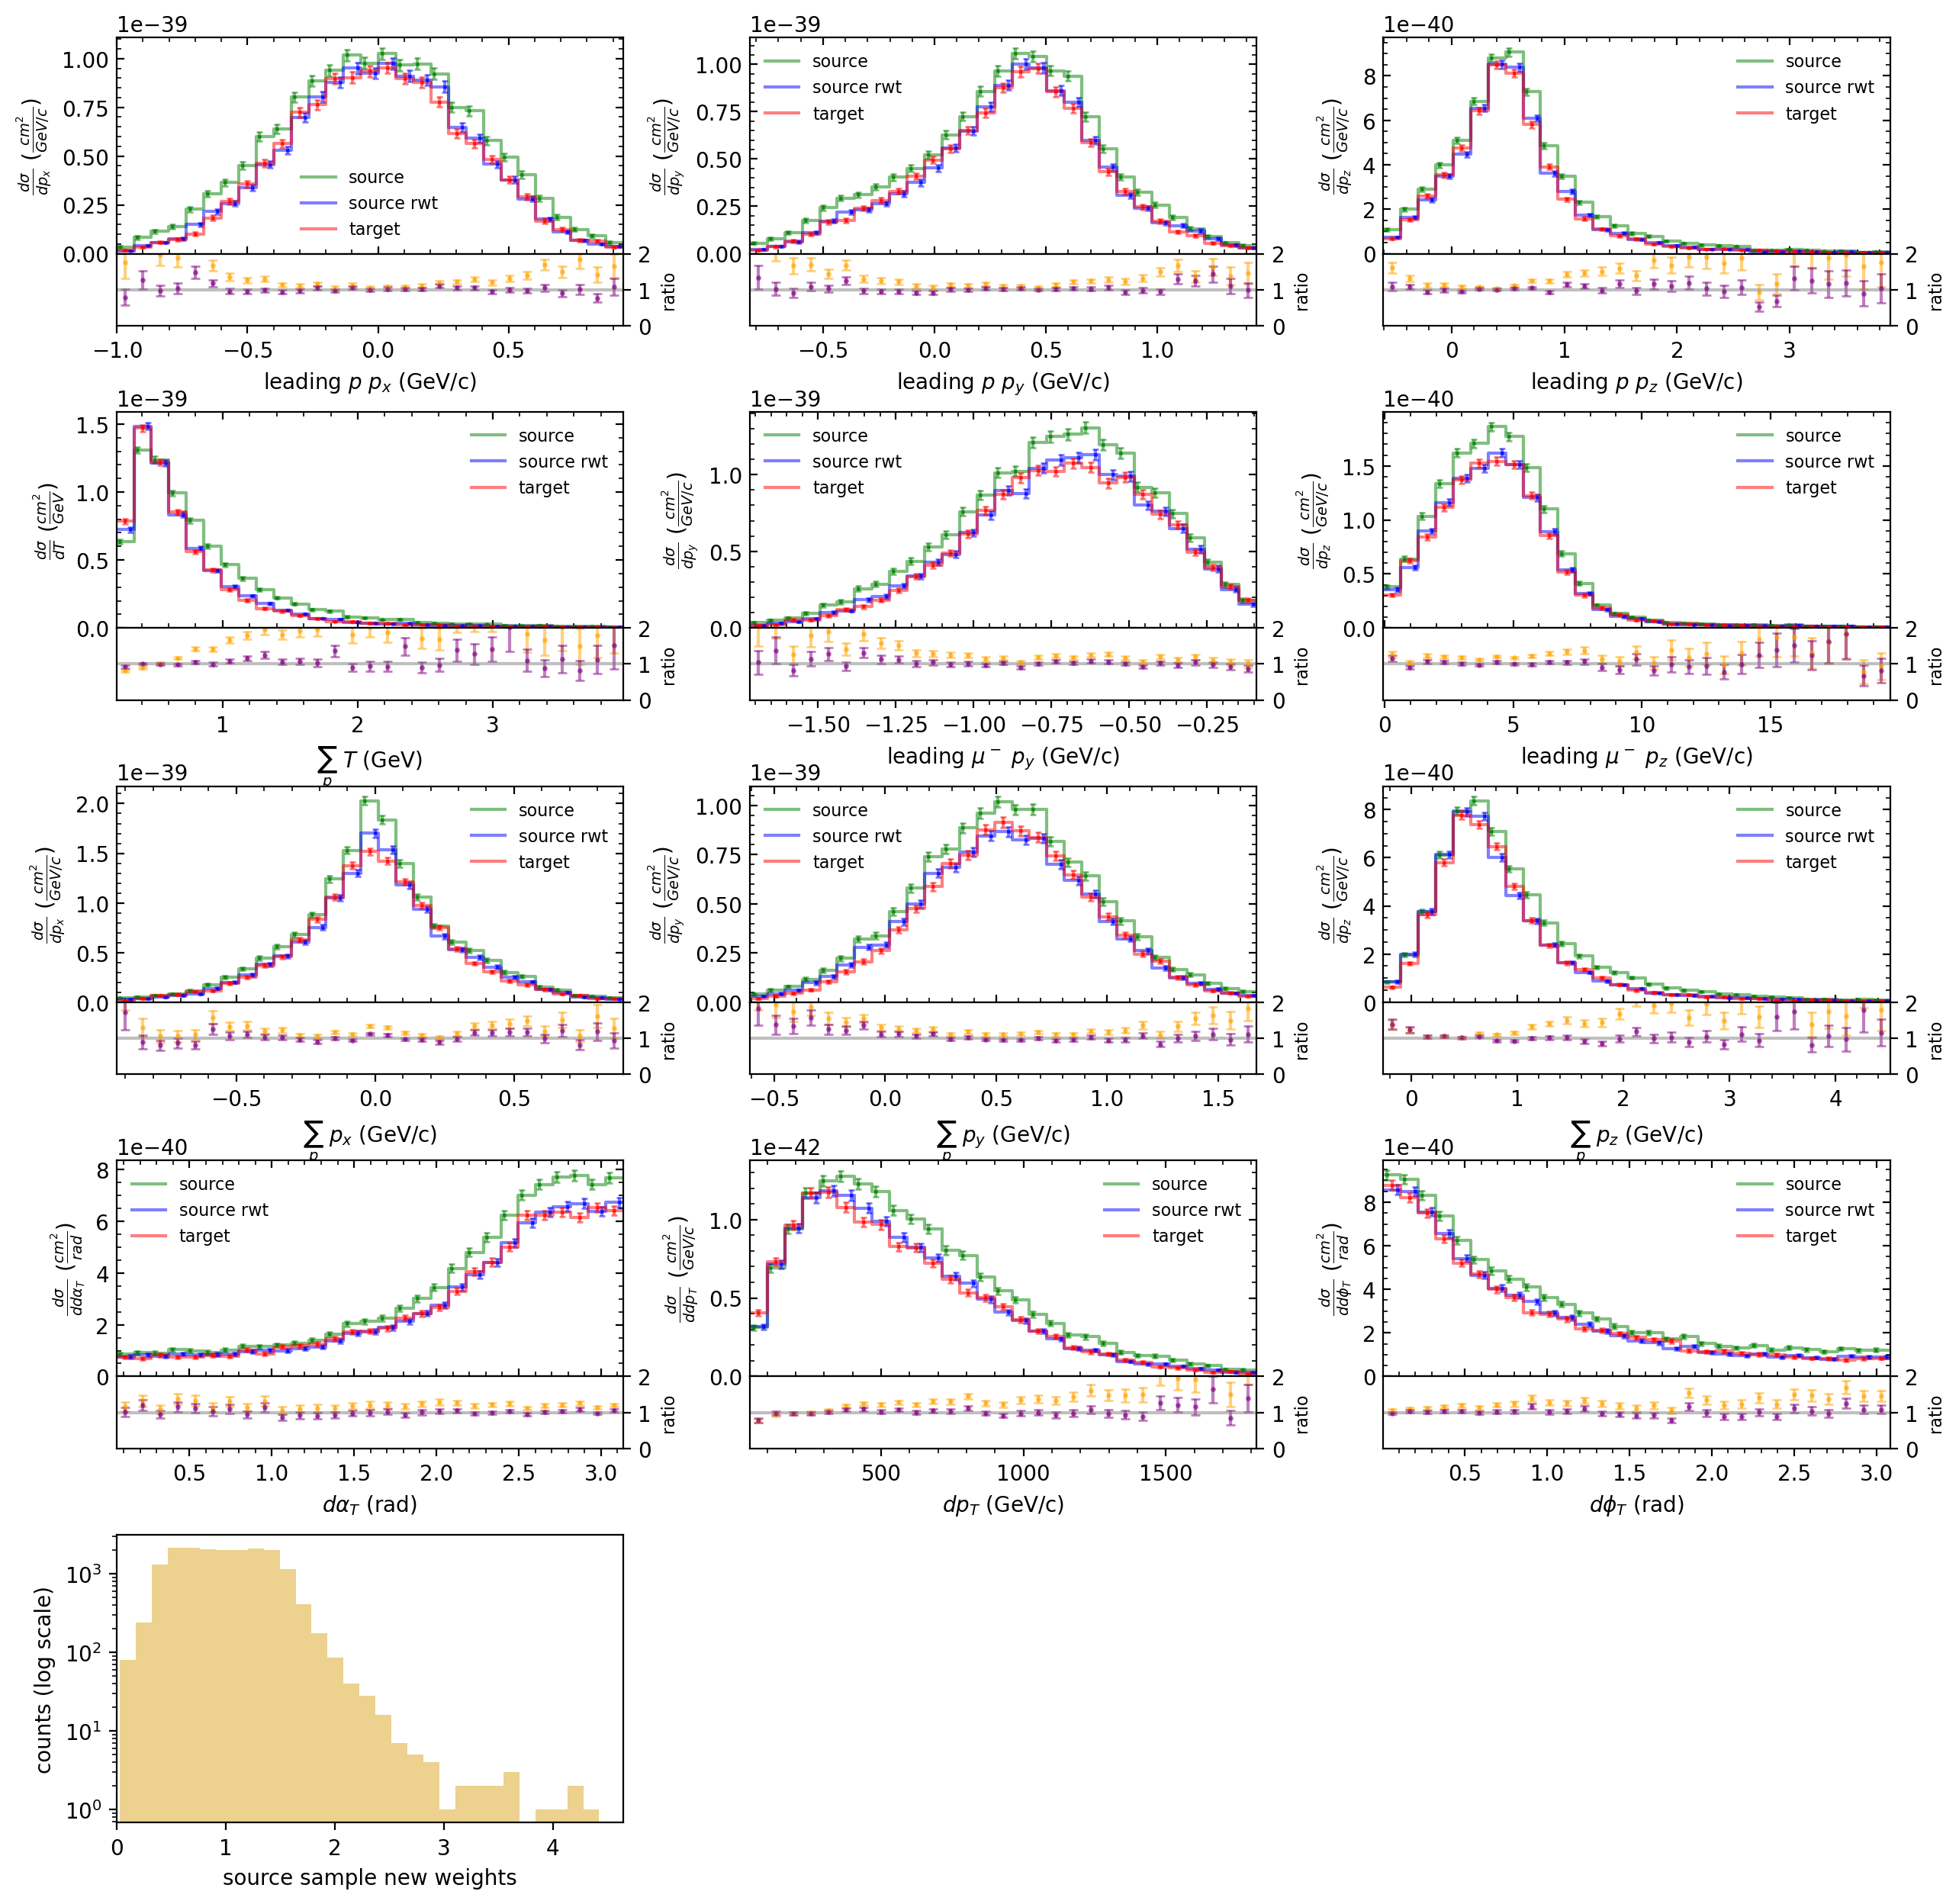

In [18]:
# Set target weights to 1.0 for all events:
target_test[category]['weight'] = 1.0

# Specify variables to be plotted as histograms:
drawing_variables = [
    'leading_proton_px','leading_proton_py','leading_proton_pz',
    'total_proton_KE','leading_muon_py','leading_muon_pz', 
    'total_proton_px','total_proton_py','total_proton_pz', 
    'dalphat', 'dpt', 'dphit', 'weight'
]

# Predict weights for source model:
source_test[category]['weight'] = reweighter.predict_matched_total_weights(
    source_test[category][reweight_variables], 
    original_weight=None,
    target_weight=target_test[category]['weight']
)

# Draw distribution histograms:
draw_source_target_distributions_and_ratio(source_test[category], target_test[category], 
    variables = drawing_variables,
    source_weights = np.ones(len(source_test[category])),
    target_weights = np.ones(len(target_test[category])), 
    new_source_weights = source_test[category]['weight'],
    xlabels = [particle_variable_to_latex(var) for var in drawing_variables],
    ylabels = [diff_xsec_latex_wrt_variable(var) for var in drawing_variables],
    scale_source = scale_source_test, scale_target = scale_target_test
)

# Save reweighter to a path:
reweighter.save_to_pickle(f'/exp/minerva/data/users/zihaolin/BDTReweighters/saved_reweighters_pickle/reweighter_MINERvA_ME_numuCarbon_CCQELike_GENIEv2_to_v3AR23_1mu{category}.pkl')


### Save or load Reweighter via Python pickle

In [19]:
# # Save to a path:
# reweighter.save_to_pickle('/exp/minerva/data/users/zihaolin/BDTReweighters/saved_reweighters_pickle/reweighter_MINERvA_ME_numuCarbon_CCQELike_GENIEv2_to_v3AR23_1mu1p0n.pkl')

# # Load from path:
# reweighter = Reweighter.load_from_pickle(
# '/exp/minerva/data/users/zihaolin/BDTReweighters/saved_reweighters_pickle/reweighter_MINERvA_ME_numuCarbon_CCQELike_GENIEv2_to_v3AR23_1mu1p0n.pkl')


### Combine categories with $\ge$ 1 proton(s) above KE threshold

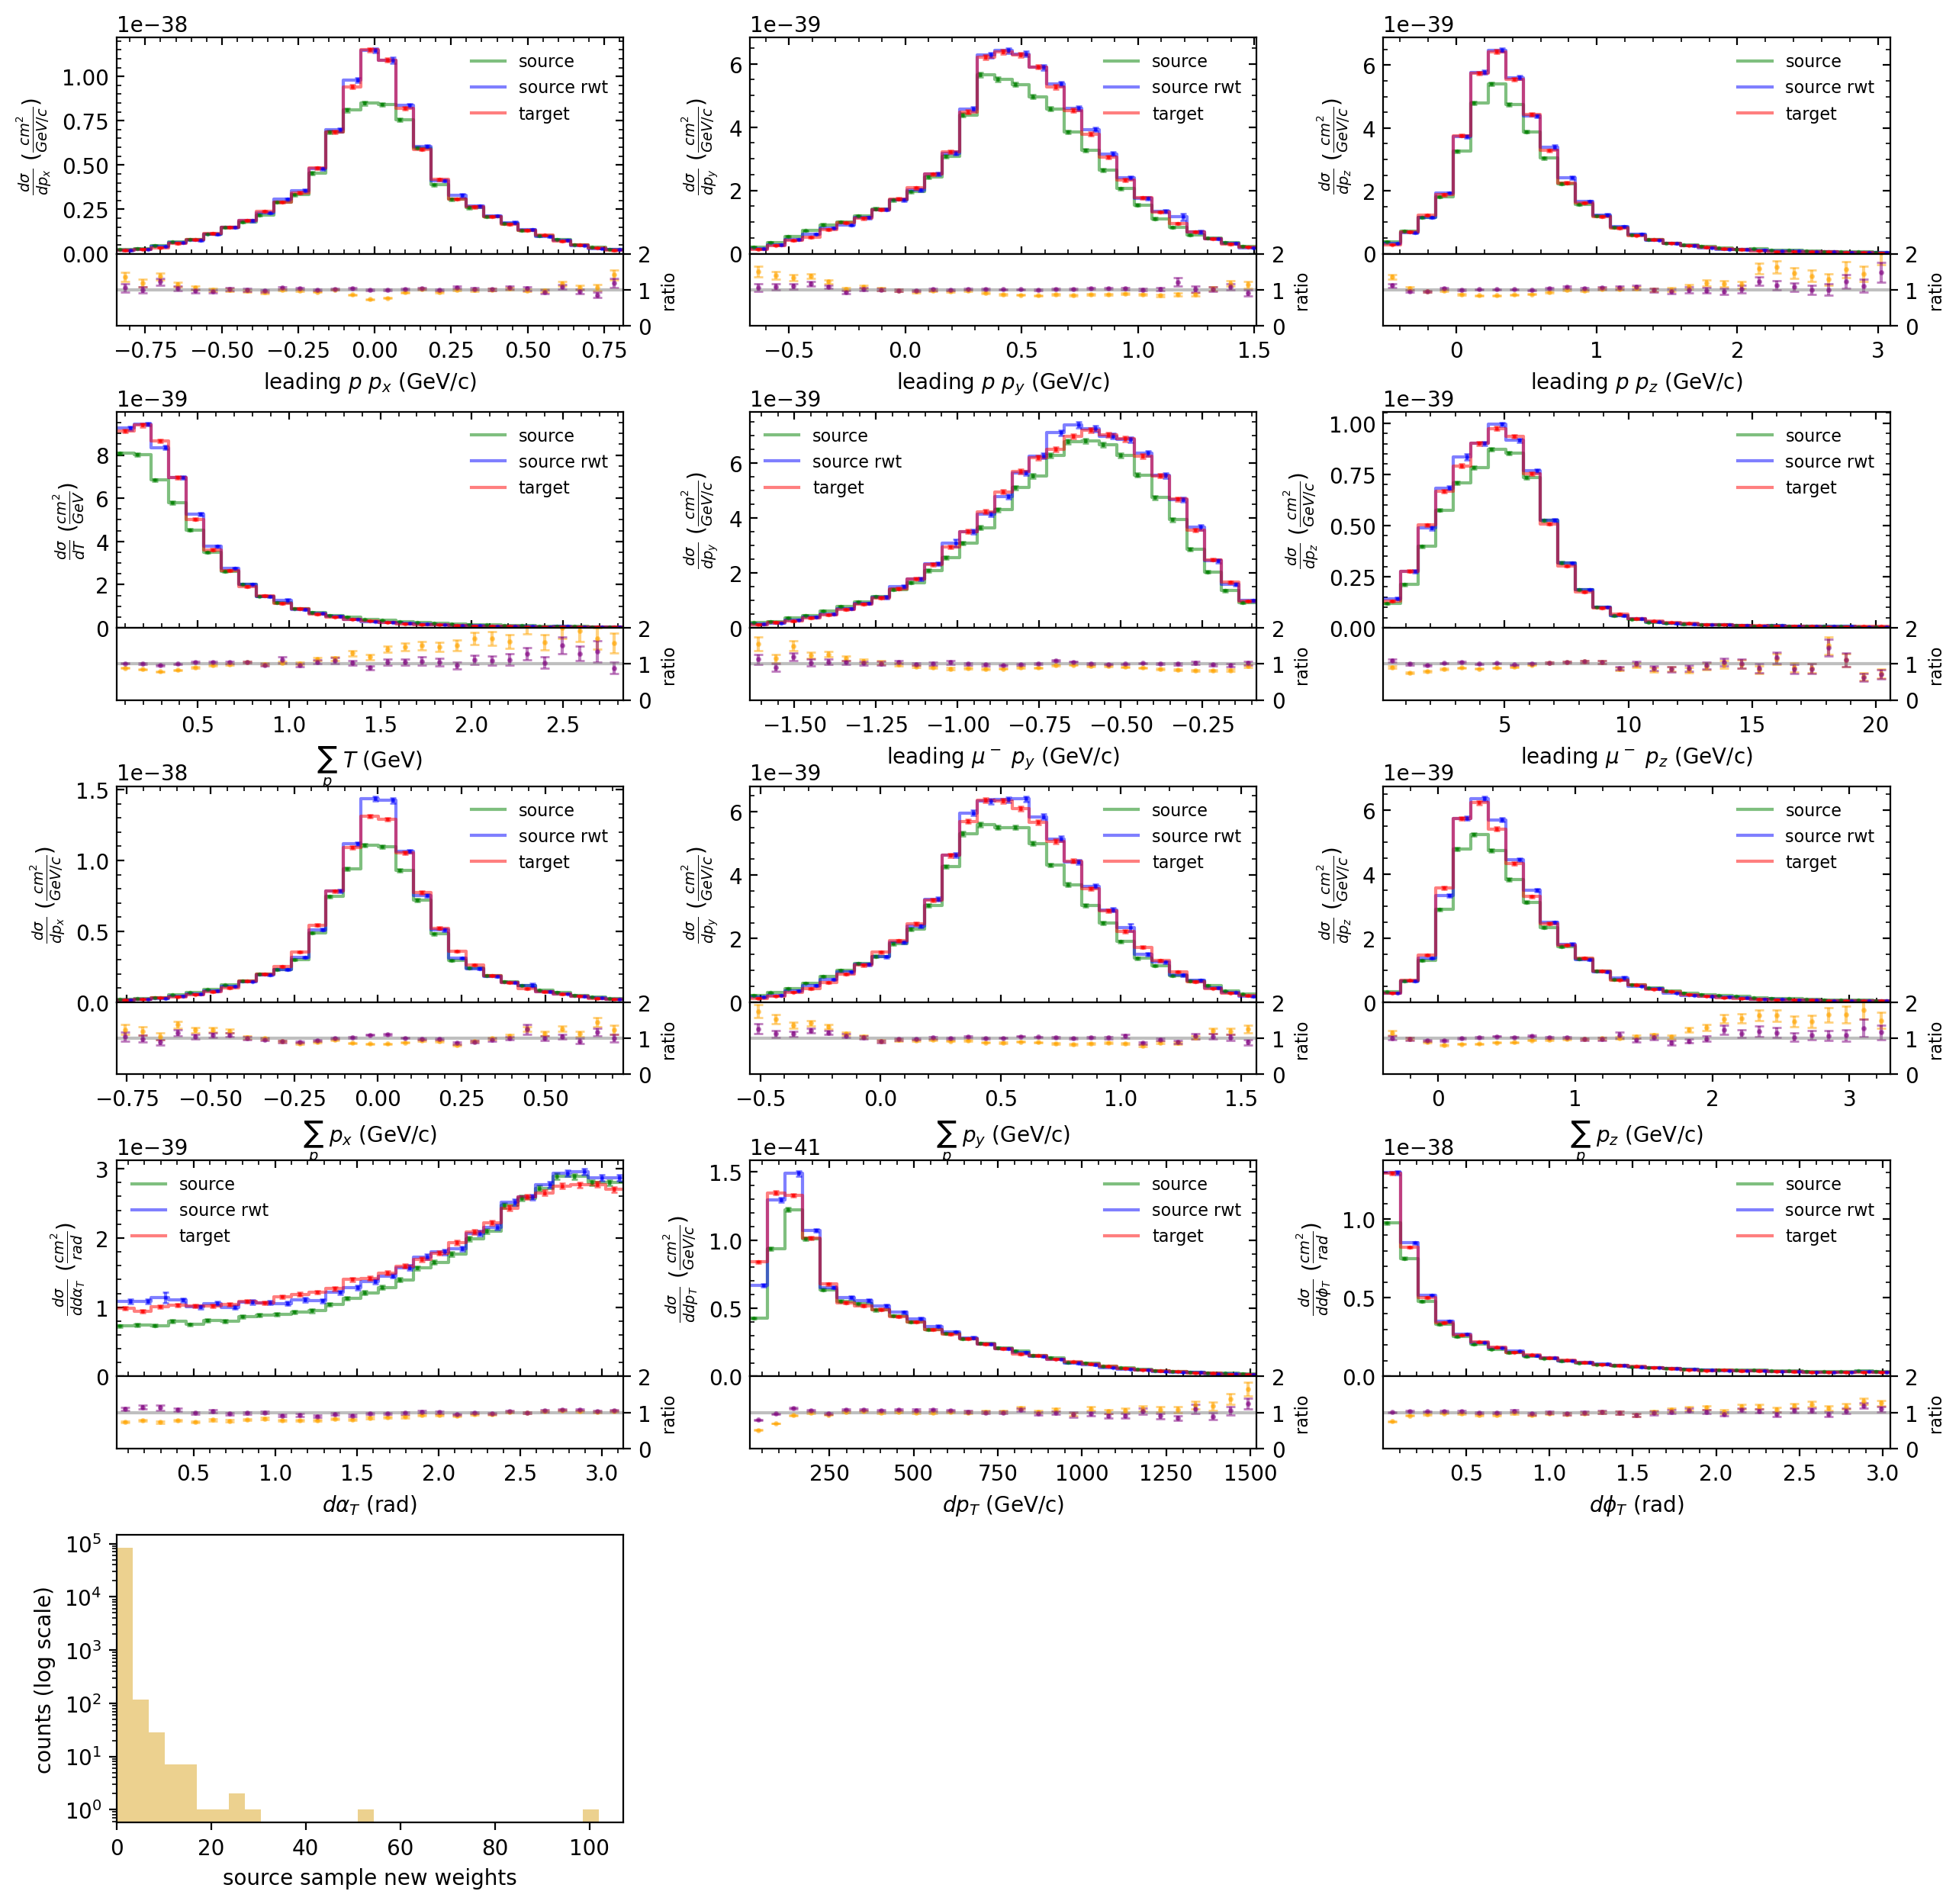

In [20]:
# Category'1p0n', '1pNn', '2p0n', '2pNn', 'others':
drawing_variables = [
    'leading_proton_px','leading_proton_py','leading_proton_pz',
    'total_proton_KE','leading_muon_py','leading_muon_pz', 
    'total_proton_px','total_proton_py','total_proton_pz', 
    'dalphat', 'dpt', 'dphit', 'weight'
]

source_test_leading_proton = pd.concat([
        source_test['1p0n'][drawing_variables], source_test['1pNn'][drawing_variables], source_test['2p0n'][drawing_variables],
        source_test['2pNn'][drawing_variables], source_test['others'][drawing_variables]
])

target_test_leading_proton = pd.concat([
        target_test['1p0n'][drawing_variables], target_test['1pNn'][drawing_variables], target_test['2p0n'][drawing_variables],
        target_test['2pNn'][drawing_variables], target_test['others'][drawing_variables]
])


# Draw distribution histograms:
draw_source_target_distributions_and_ratio(source_test_leading_proton, target_test_leading_proton, 
    variables = drawing_variables,
    source_weights = np.ones(len(source_test_leading_proton)),
    target_weights = np.ones(len(target_test_leading_proton)), 
    new_source_weights = source_test_leading_proton['weight'],
    xlabels = [particle_variable_to_latex(var) for var in drawing_variables],
    ylabels = [diff_xsec_latex_wrt_variable(var) for var in drawing_variables],
    scale_source = scale_source_test, scale_target = scale_target_test
)


### Combine all categories

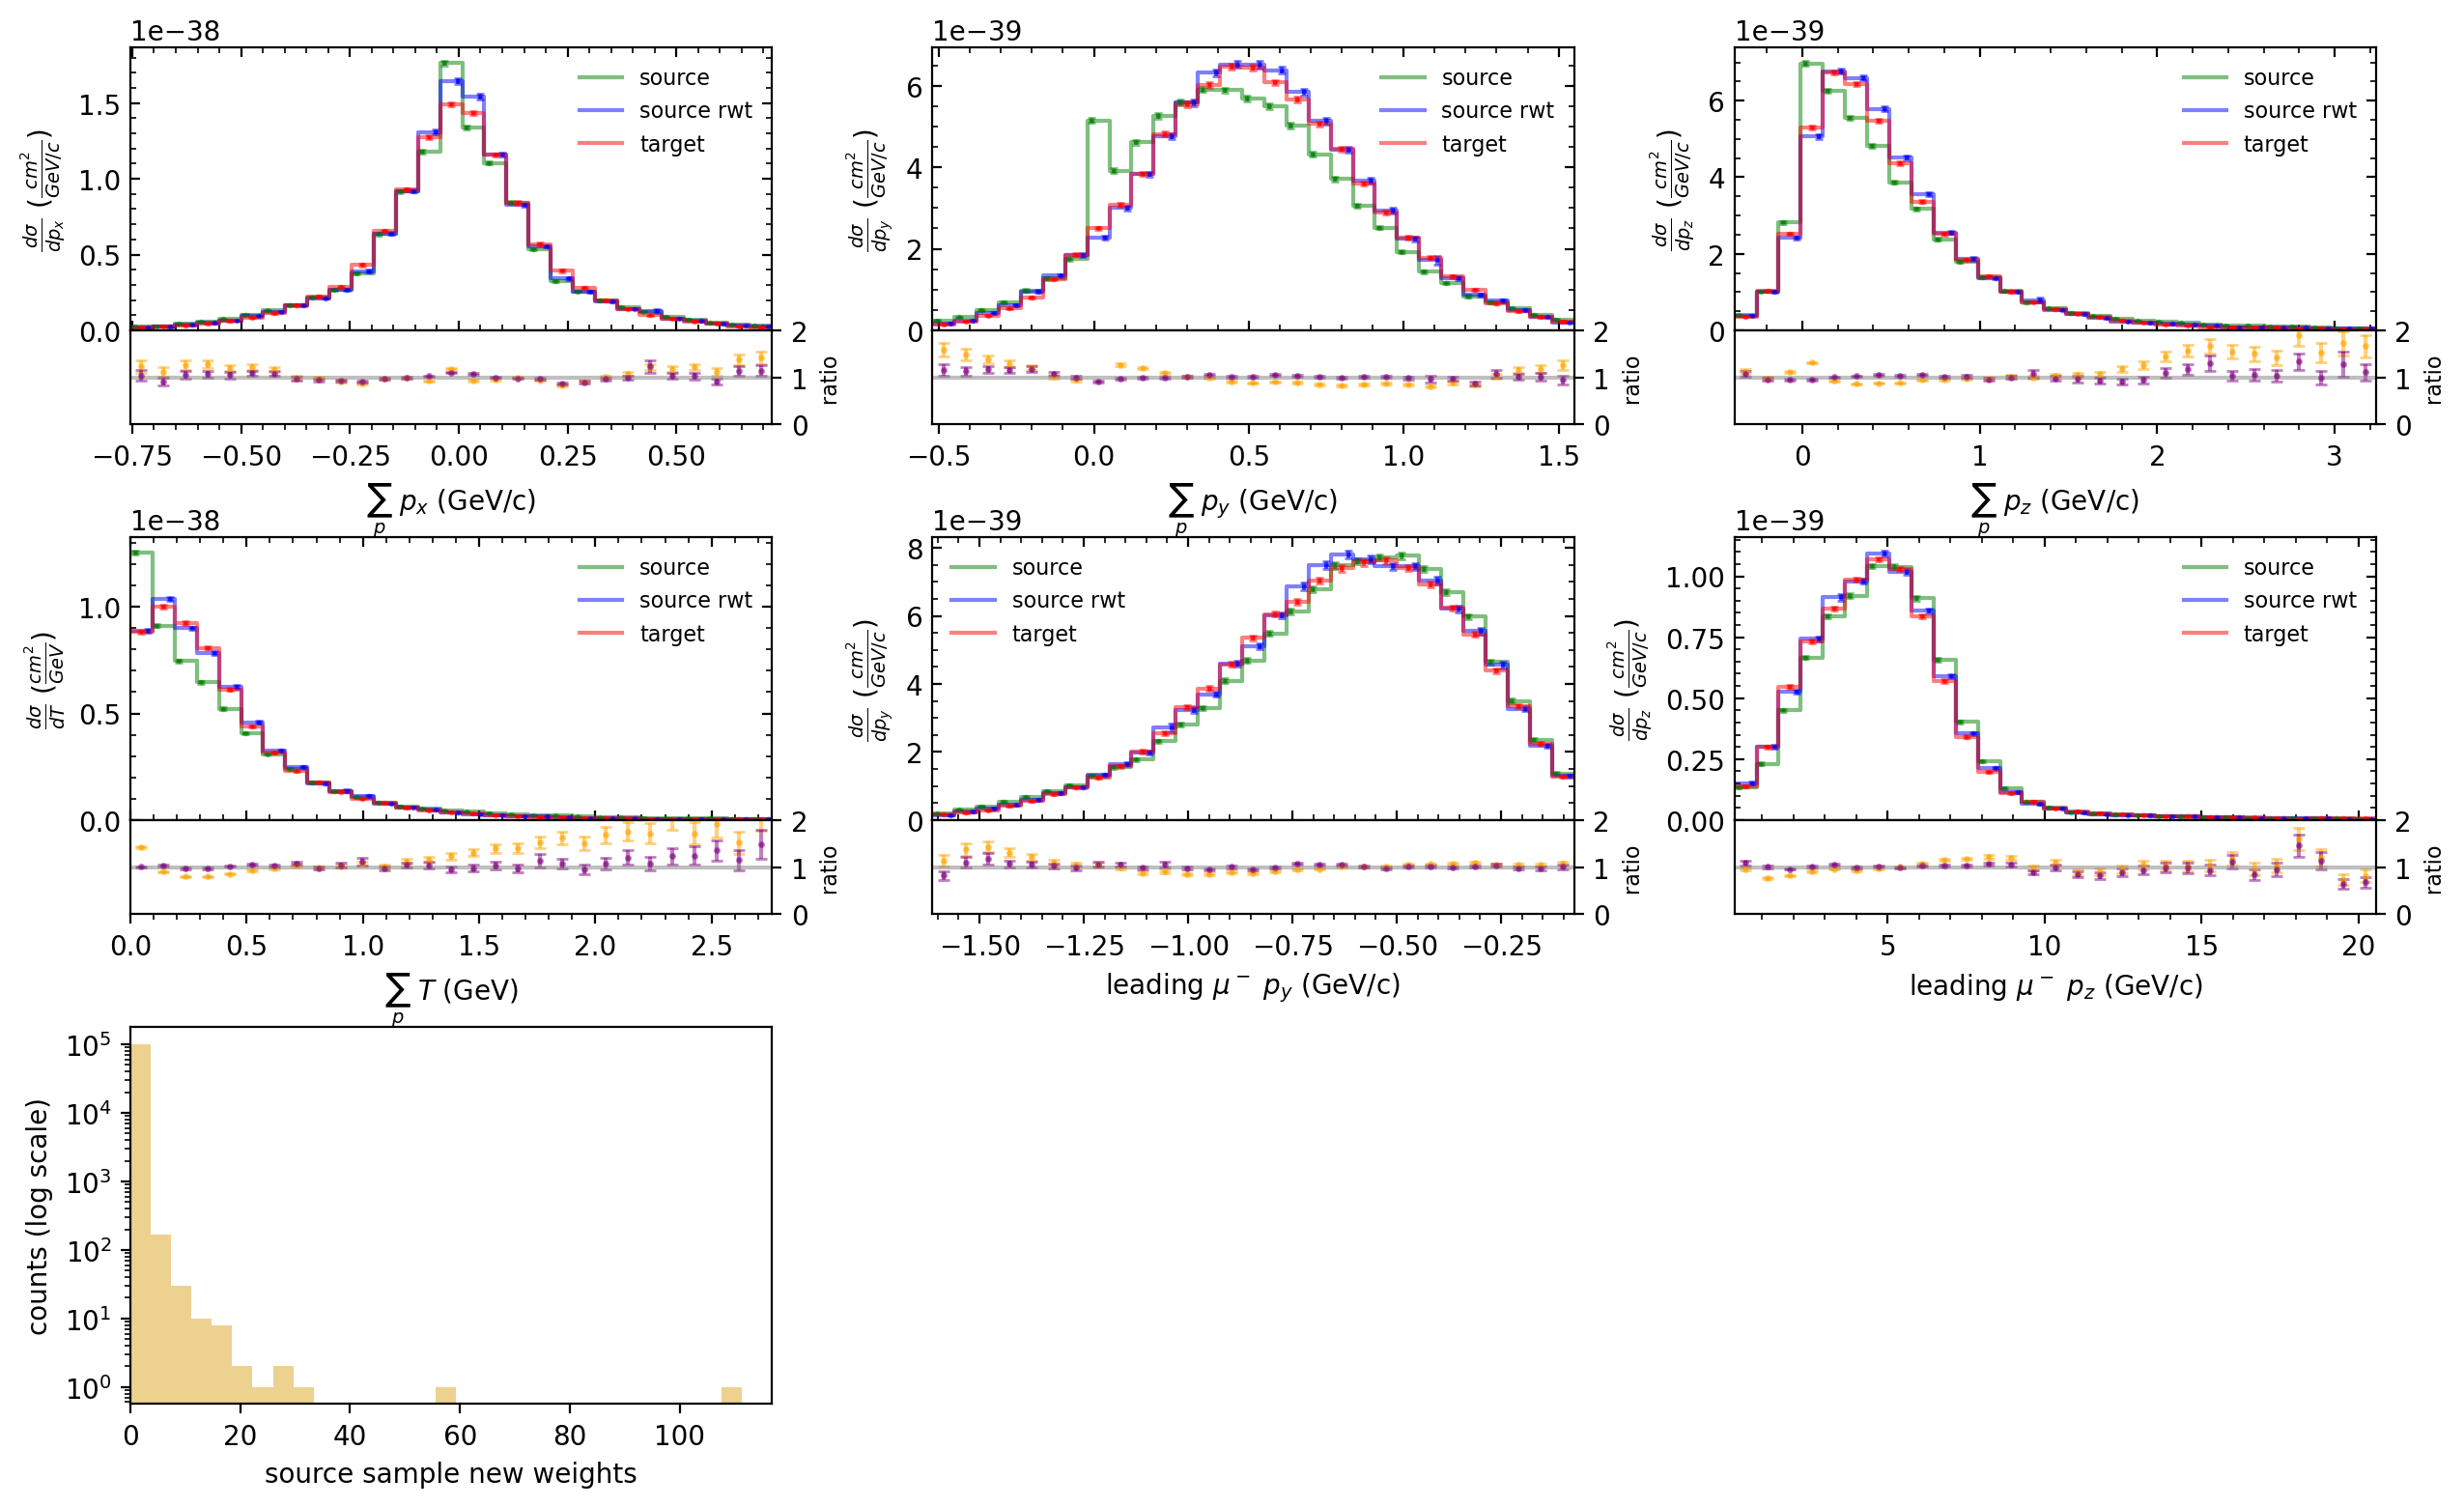

In [21]:
# All categories.
drawing_variables = [
    'total_proton_px','total_proton_py','total_proton_pz', 
    'total_proton_KE','leading_muon_py','leading_muon_pz', 
    'weight'
]

source_test_all = pd.concat([
        source_test['0p0n'][drawing_variables], source_test['0pNn'][drawing_variables],
        source_test['1p0n'][drawing_variables], source_test['1pNn'][drawing_variables], source_test['2p0n'][drawing_variables],
        source_test['2pNn'][drawing_variables], source_test['others'][drawing_variables]
])

target_test_all = pd.concat([
        target_test['0p0n'][drawing_variables], target_test['0pNn'][drawing_variables],
        target_test['1p0n'][drawing_variables], target_test['1pNn'][drawing_variables], target_test['2p0n'][drawing_variables],
        target_test['2pNn'][drawing_variables], target_test['others'][drawing_variables]
])


# Draw distribution histograms:
draw_source_target_distributions_and_ratio(source_test_all, target_test_all, 
    variables = drawing_variables,
    source_weights = np.ones(len(source_test_all)),
    target_weights = np.ones(len(target_test_all)), 
    new_source_weights = source_test_all['weight'],
    xlabels = [particle_variable_to_latex(var) for var in drawing_variables],
    ylabels = [diff_xsec_latex_wrt_variable(var) for var in drawing_variables],
    scale_source = scale_source_test, scale_target = scale_target_test
)
